# Test for group differences in the Bayesian way

_Author: Christoph Rahmede_

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-1">Load the data</a></span></li><li><span><a href="#Group-differences-and-frequentist-t-test" data-toc-modified-id="Group-differences-and-frequentist-t-test-2">Group differences and frequentist t-test</a></span></li><li><span><a href="#Differences-in-statistics-based-on-origin" data-toc-modified-id="Differences-in-statistics-based-on-origin-3">Differences in statistics based on origin</a></span><ul class="toc-item"><li><span><a href="#Trace-plot" data-toc-modified-id="Trace-plot-3.1">Trace plot</a></span></li><li><span><a href="#Vectorized-version" data-toc-modified-id="Vectorized-version-3.2">Vectorized version</a></span></li><li><span><a href="#Trace-plot" data-toc-modified-id="Trace-plot-3.3">Trace plot</a></span></li><li><span><a href="#Posterior-predictive-samples" data-toc-modified-id="Posterior-predictive-samples-3.4">Posterior predictive samples</a></span></li><li><span><a href="#Forest-plot" data-toc-modified-id="Forest-plot-3.5">Forest plot</a></span></li></ul></li><li><span><a href="#Modifying-the-model" data-toc-modified-id="Modifying-the-model-4">Modifying the model</a></span><ul class="toc-item"><li><span><a href="#Forest-plot" data-toc-modified-id="Forest-plot-4.1">Forest plot</a></span></li></ul></li><li><span><a href="#Differences-between-brands" data-toc-modified-id="Differences-between-brands-5">Differences between brands</a></span><ul class="toc-item"><li><span><a href="#Forest-plot" data-toc-modified-id="Forest-plot-5.1">Forest plot</a></span></li><li><span><a href="#Trace-plot" data-toc-modified-id="Trace-plot-5.2">Trace plot</a></span></li></ul></li><li><span><a href="#Hierarchical-model-of-origin-and-brands" data-toc-modified-id="Hierarchical-model-of-origin-and-brands-6">Hierarchical model of origin and brands</a></span><ul class="toc-item"><li><span><a href="#Forest-plot" data-toc-modified-id="Forest-plot-6.1">Forest plot</a></span></li><li><span><a href="#Trace-plot" data-toc-modified-id="Trace-plot-6.2">Trace plot</a></span></li><li><span><a href="#Model-summary" data-toc-modified-id="Model-summary-6.3">Model summary</a></span></li><li><span><a href="#Adjusted-means" data-toc-modified-id="Adjusted-means-6.4">Adjusted means</a></span></li></ul></li><li><span><a href="#Robust-model" data-toc-modified-id="Robust-model-7">Robust model</a></span><ul class="toc-item"><li><span><a href="#Forest-plot" data-toc-modified-id="Forest-plot-7.1">Forest plot</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-7.2">Summary</a></span></li></ul></li></ul></div>

Previously we looked at frequentist hypothesis tests like the t-test to assess the significance of observed differences in sample means. The result allowed us to accept or reject the null hypothesis of equal means. 

We can do something similar in a Bayesian context by determining the probability of a certain difference of means given the observed samples. We can develop MCMC models with much weaker assumptions and applicable to testing differences of arbitrary statistics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import pymc3 as pm
import arviz as az

## Load the data

We will work with the dataset we know already very well.

In [3]:
df = pd.read_csv(
    '/Users/maartenk/Documents/git/DsMasterClass/dataset-collection/auto-mpg/auto-mpg.csv', sep='\s+', header=None)
df.columns = ['mpg', 'cylinders', 'displacement', 'horsepower',
              'weight', 'acceleration', 'year', 'origin', 'name']
df.drop(df[df.horsepower == '?'].index, inplace=True)
df['horsepower'] = df.horsepower.astype(float)
df['brand'] = df.name.map(lambda x: x.split(' ')[0]
                          ).replace(
    {'toyouta': 'toyota',
     'maxda': 'mazda',
     'chevroelt': 'chevrolet',
     'vw': 'volkswagen',
     'vokswagen': 'volkswagen',
     'mercedes-benz': 'mercedes'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 10 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null float64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
brand           392 non-null object
dtypes: float64(5), int64(3), object(2)
memory usage: 33.7+ KB


In [4]:
df.head()

mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0  18.0          8         307.0       130.0  3504.0          12.0    70   
1  15.0          8         350.0       165.0  3693.0          11.5    70   
2  18.0          8         318.0       150.0  3436.0          11.0    70   
3  16.0          8         304.0       150.0  3433.0          12.0    70   
4  17.0          8         302.0       140.0  3449.0          10.5    70   

   origin                       name      brand  
0       1  chevrolet chevelle malibu  chevrolet  
1       1          buick skylark 320      buick  
2       1         plymouth satellite   plymouth  
3       1              amc rebel sst        amc  
4       1                ford torino       ford

## Group differences and frequentist t-test

We will be interested in differences between group means and standard deviations.

In [5]:
grouped_origin = df.groupby('origin')[['mpg']].agg([np.mean,np.std, lambda x: len(x)])
grouped_origin

mpg                   
             mean       std <lambda>
origin                              
1       20.033469  6.440384    245.0
2       27.602941  6.580182     68.0
3       30.450633  6.090048     79.0

As a reminder, we calculate the frequentist t-test results.

In [6]:
from scipy import stats
from itertools import combinations

In [7]:
for comb in combinations(df.origin.unique(), 2):
    t_test_result = stats.ttest_ind(
        df.mpg[df.origin == comb[0]], df.mpg[df.origin == comb[1]])
    print(comb, t_test_result.statistic, t_test_result.pvalue)

(1, 3) -12.664889006229084 4.17283714676552e-30
(1, 2) -8.534455914399228 6.306531719750568e-16
(3, 2) 2.723324735392516 0.007256875026960007


Create dummy variables for the origin:

In [8]:
df['american'] = df.origin.map(lambda x: 1 if x==1 else 0)
df['european'] = df.origin.map(lambda x: 1 if x==2 else 0)
df['asian'] = df.origin.map(lambda x: 1 if x==3 else 0)

Get the group observed values:

In [9]:
american_mpg = df.mpg[df.american==1]
european_mpg = df.mpg[df.european==1]
asian_mpg = df.mpg[df.asian==1]

As a reference, we obtain some statistics of the whole dataset. We will use those for formulating prior believes.

In [10]:
prior_mean = df.mpg.mean()
prior_std = df.mpg.std()
print(prior_mean, prior_std)

23.44591836734694 7.805007486571799


## Differences in statistics based on origin

We now set up a pymc3 model for determining the likely values for means and standard deviations in each group given the data.

As rather uninformed priors, we set up normal distributions centered on the mean of the whole group and with a standard deviation so large that we hardly limit the range of possible values. 

For the standard deviations of each group, we define an uninformed prior through a continuous uniform distribution between a very low and sufficiently high value. Since this distribution has support on a finite interval, any values outside that range will not be possible.

The likelihood function chosen as normal distributions for each group picks up the prior means and standard deviations of each group and the observed data per group.

We added deterministic distributions calculating differences of means and standard deviations for each pair of the groups for the values created in each sampling step. The individually sampled values are (pseudo-)random, but taking their differences does not add any further randomness. We could calculate these differences as well from the trace results. The benefit of defining these additional distributions is that they are directly stored in the trace.

In [11]:
prior_mean_std = 50
prior_std_lower = 0.00001
prior_std_upper = 10.

In [12]:
with pm.Model() as model:
    
    #priors
    
    am_mean = pm.Normal('american_mean', prior_mean, sd=prior_mean_std)
    eu_mean = pm.Normal('european_mean', prior_mean, sd=prior_mean_std)
    as_mean = pm.Normal('asian_mean', prior_mean, sd=prior_mean_std)
    
    am_std = pm.Uniform('american_std', lower=prior_std_lower,upper=prior_std_upper)
    eu_std = pm.Uniform('european_std',lower=prior_std_lower,upper=prior_std_upper)
    as_std = pm.Uniform('asian_std',lower=prior_std_lower,upper=prior_std_upper)
    
    # likelihood
    
    am_mpg = pm.Normal('american_mpg', mu=am_mean, sd=am_std, observed=american_mpg)
    eu_mpg = pm.Normal('european_mpg', mu=eu_mean, sd=eu_std, observed=european_mpg)
    as_mpg = pm.Normal('asian_mpg', mu=as_mean, sd=as_std, observed=asian_mpg)
    
    # deterministic 
    
    delta_mean_am_eu = pm.Deterministic('delta_mean_am_eu', am_mean - eu_mean)
    delta_std_am_eu = pm.Deterministic('delta_std_am_eu', am_std - eu_std)
    
    delta_mean_am_as = pm.Deterministic('delta_mean_am_as', am_mean - as_mean)
    delta_std_am_as = pm.Deterministic('delta_std_am_as', am_std - as_std)
    
    delta_mean_eu_as = pm.Deterministic('delta_mean_eu_as', eu_mean-as_mean)
    delta_std_eu_as = pm.Deterministic('delta_std_euro_as', eu_std-as_std)

In [13]:
model.model

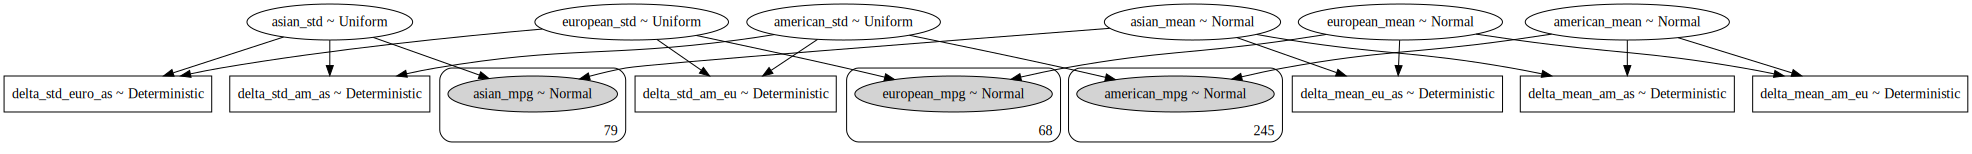

In [14]:
pm.model_to_graphviz(model)

In [16]:
with model:
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [asian_std, european_std, american_std, asian_mean, european_mean, american_mean]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:11<00:00, 1963.57draws/s]


### Trace plot

In [17]:
trace.varnames

['american_mean',
 'european_mean',
 'asian_mean',
 'american_std_interval__',
 'european_std_interval__',
 'asian_std_interval__',
 'american_std',
 'european_std',
 'asian_std',
 'delta_mean_am_eu',
 'delta_std_am_eu',
 'delta_mean_am_as',
 'delta_std_am_as',
 'delta_mean_eu_as',
 'delta_std_euro_as']

In [18]:
[name for name in trace.varnames if 'delta' not in name if '__' not in name]

['american_mean',
 'european_mean',
 'asian_mean',
 'american_std',
 'european_std',
 'asian_std']

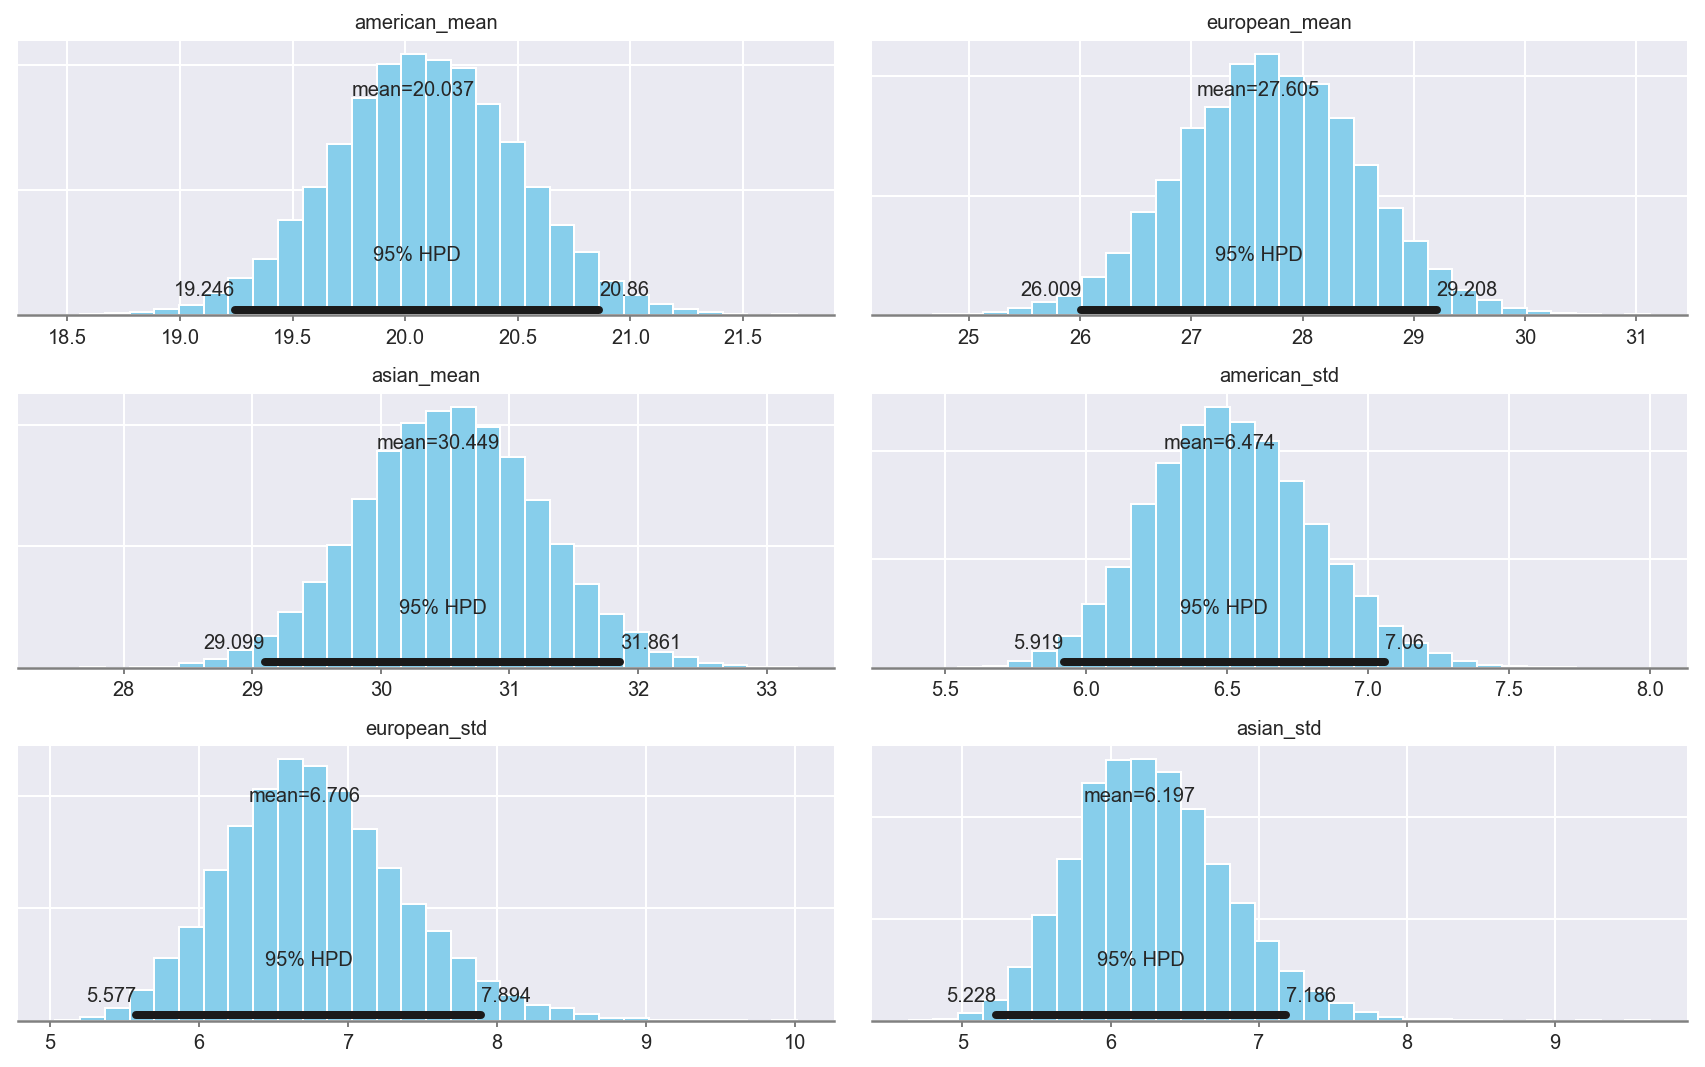

In [19]:
pm.plot_posterior(trace,varnames=[name for name in trace.varnames if 'delta' not in name if '__' not in name])    
plt.show()

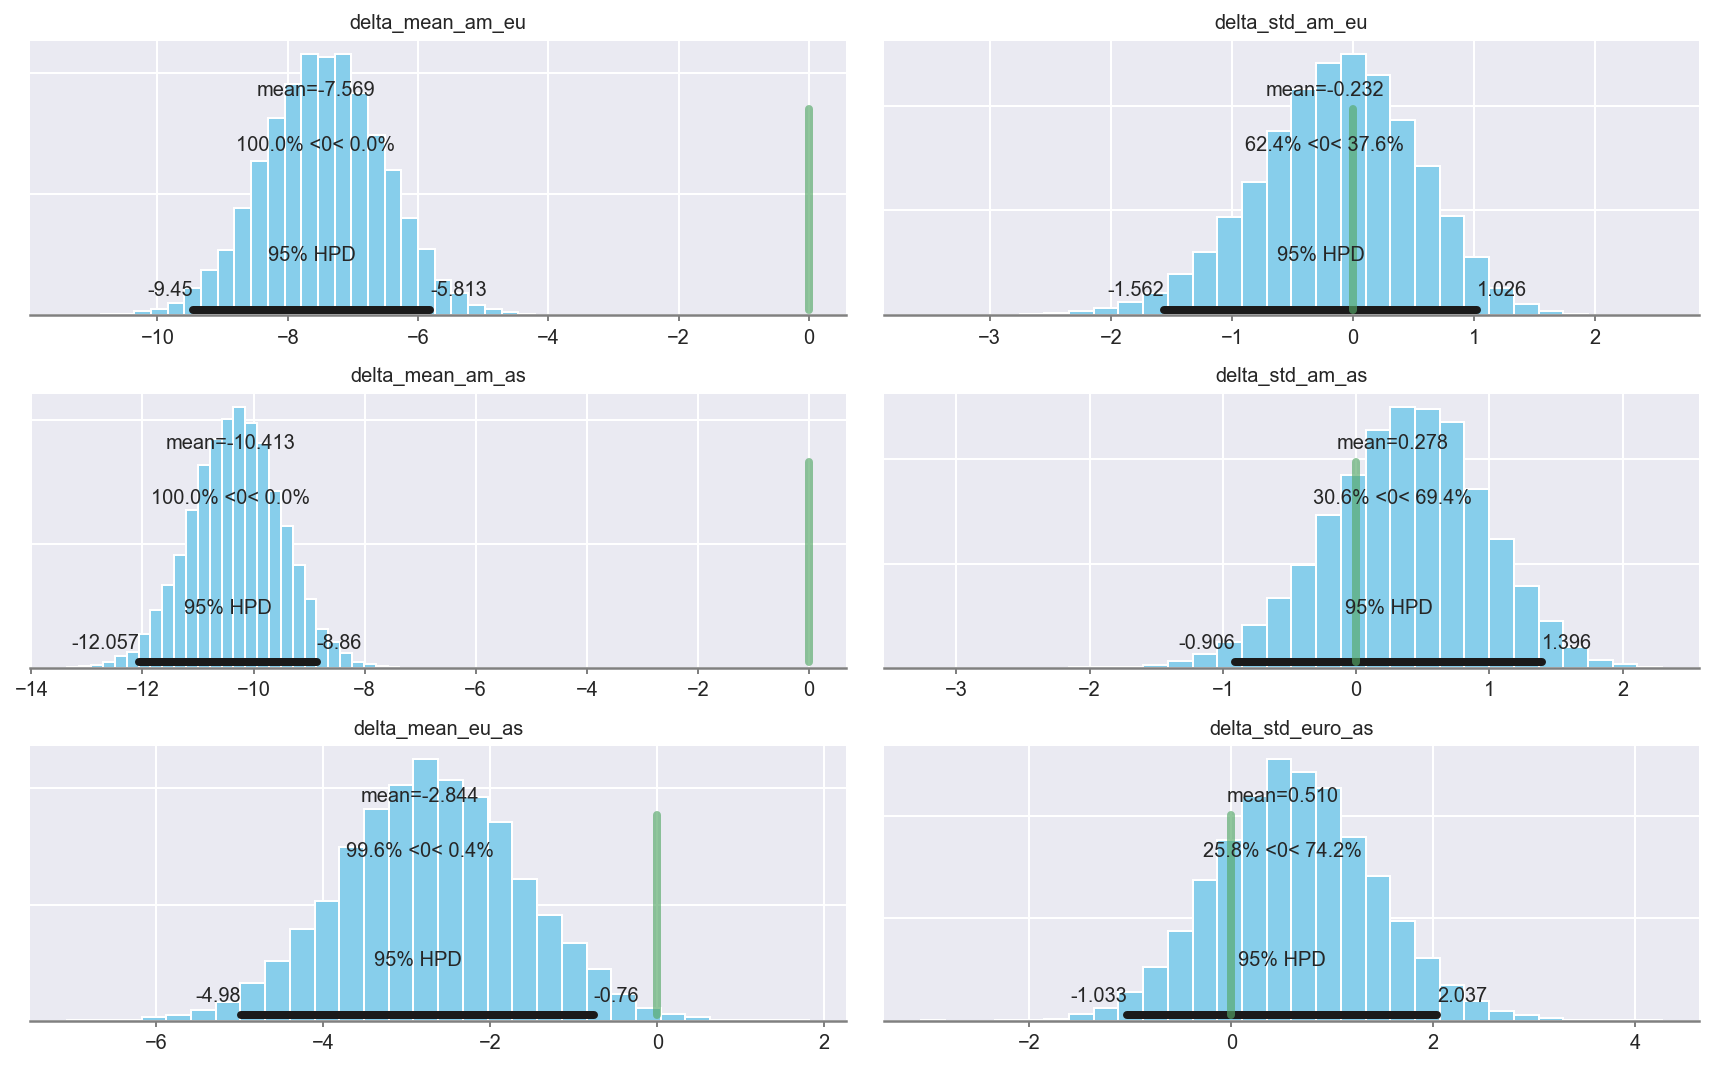

In [20]:
pm.plot_posterior(trace,varnames=[name for name in trace.varnames if 'delta' in name], ref_val=0)    
plt.show()

### Vectorized version

We wrote all the parts explicitly above, but that would be unfeasible for larger numbers of groups and comparisons. Therefore we rather vectorize the formulation of the model.

In [21]:
mpg_values = [american_mpg.values, european_mpg.values, asian_mpg.values]

In [22]:
from itertools import combinations

In [23]:
list(combinations(range(3),2))

[(0, 1), (0, 2), (1, 2)]

In [24]:
n_groups = 3

In [25]:
with pm.Model() as model_v:
    
    mean = pm.Normal('mean', prior_mean, sd=prior_mean_std, shape=n_groups)
    std = pm.Uniform('std', lower=prior_std_lower,upper=prior_std_upper, shape=n_groups)
    
    mpg = {}
    
    for i, observed in enumerate(mpg_values):
        mpg[i] = pm.Normal('{}'.format(i), mu=mean[i], sd=std[i], observed=mpg_values[i])

    mean_delta = {}
    std_delta = {}
    
    for i,j in combinations(range(n_groups),2):
        mean_delta[(i,j)] = pm.Deterministic('delta_mean_{}'.format((i,j)), mean[i]-mean[j])
        std_delta[(i,j)] = pm.Deterministic('delta_std_{}'.format((i,j)), std[i]-std[j])

In [26]:
with model_v:
    trace_v = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std, mean]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:13<00:00, 1608.98draws/s]


### Trace plot

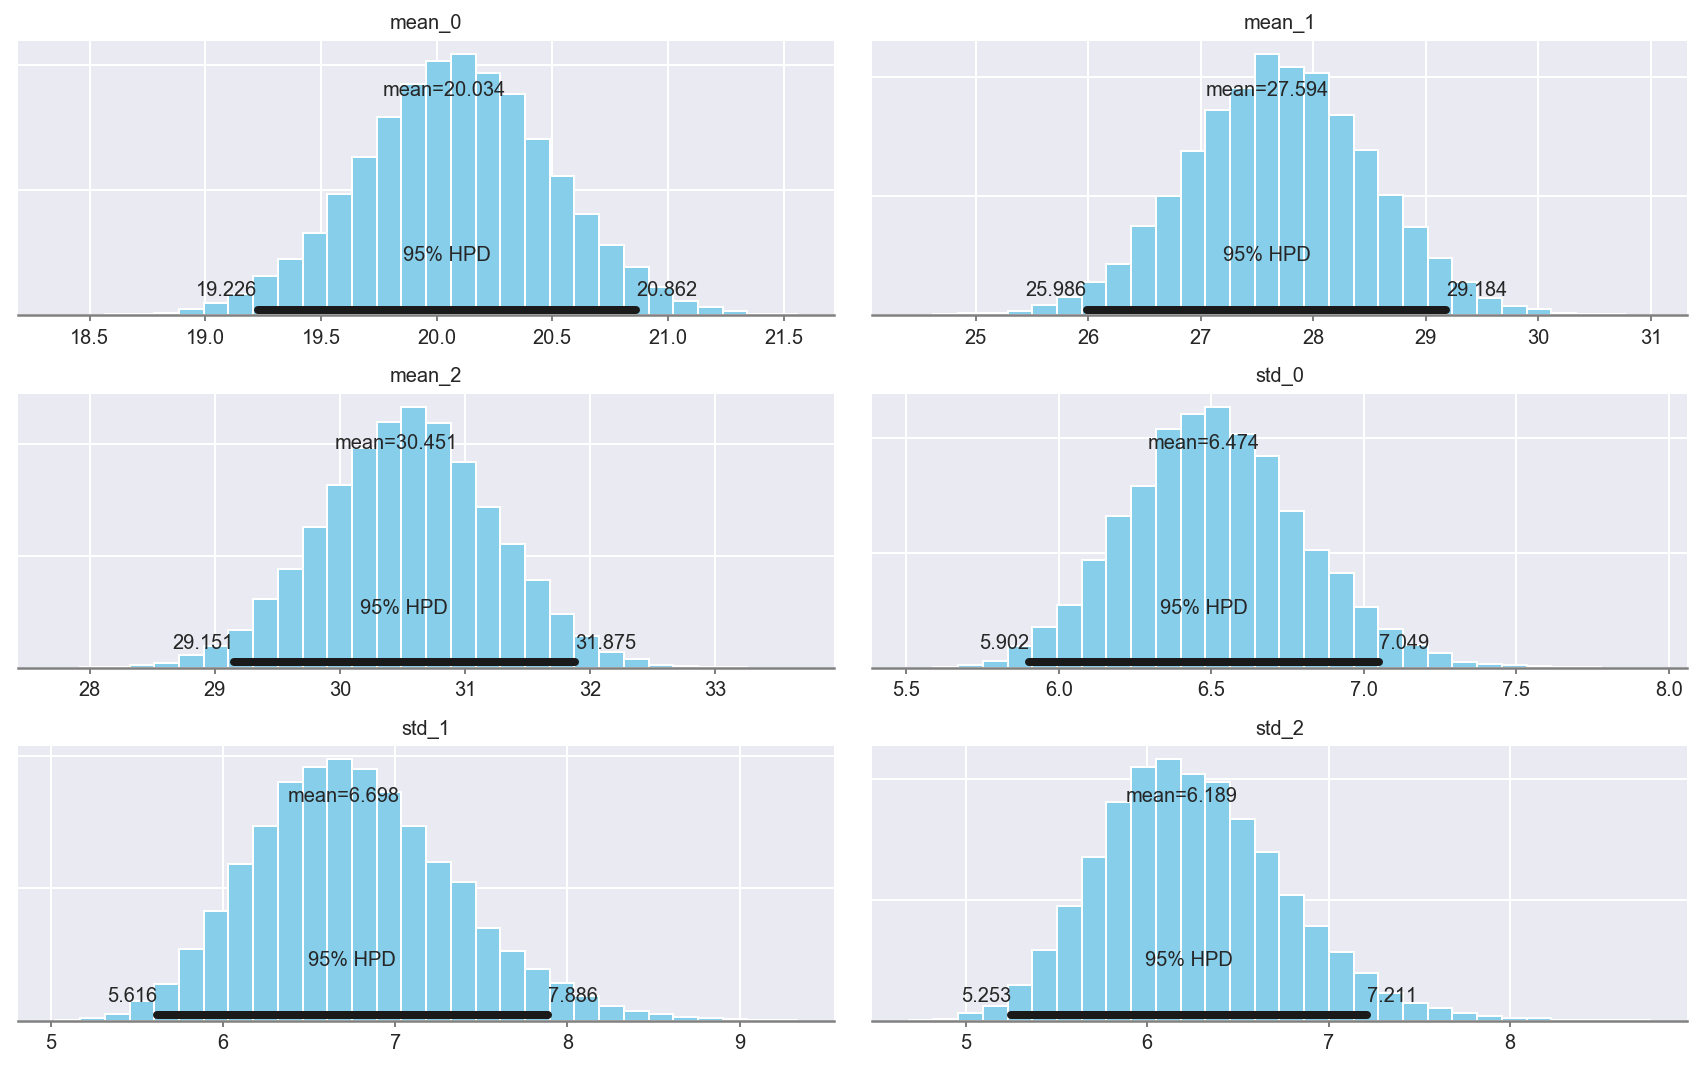

In [27]:
pm.plot_posterior(trace_v, varnames=['mean','std'])    
plt.show()

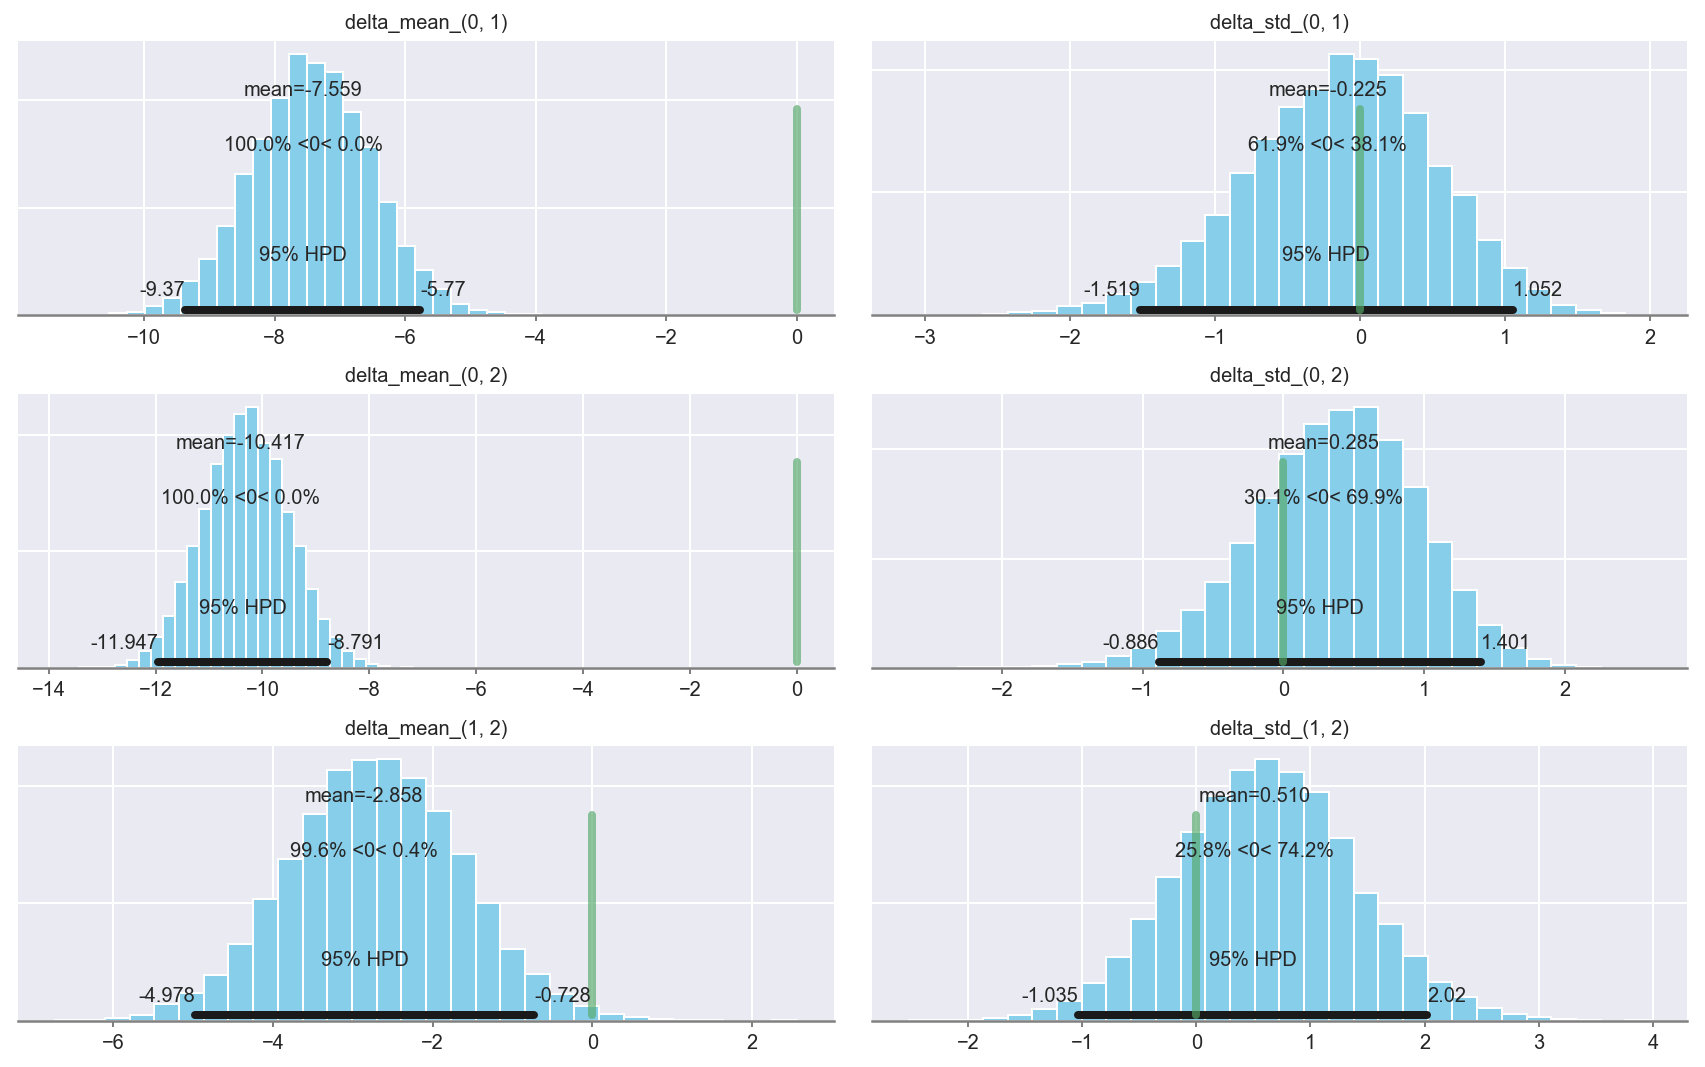

In [28]:
pm.plot_posterior(trace_v, varnames=[name for name in trace_v.varnames if 'delta' in name],ref_val=0)    
plt.show()

### Posterior predictive samples

We can sample from the posterior to obtain predictions for the distribution of the group means. Arviz is useful for that purpose.

In [29]:
posterior_predictive = pm.sample_posterior_predictive(trace_v,samples=100,model=model_v)

100%|██████████| 100/100 [00:01<00:00, 79.21it/s]


In [30]:
az_data = az.from_pymc3(trace=trace_v,posterior_predictive=posterior_predictive)

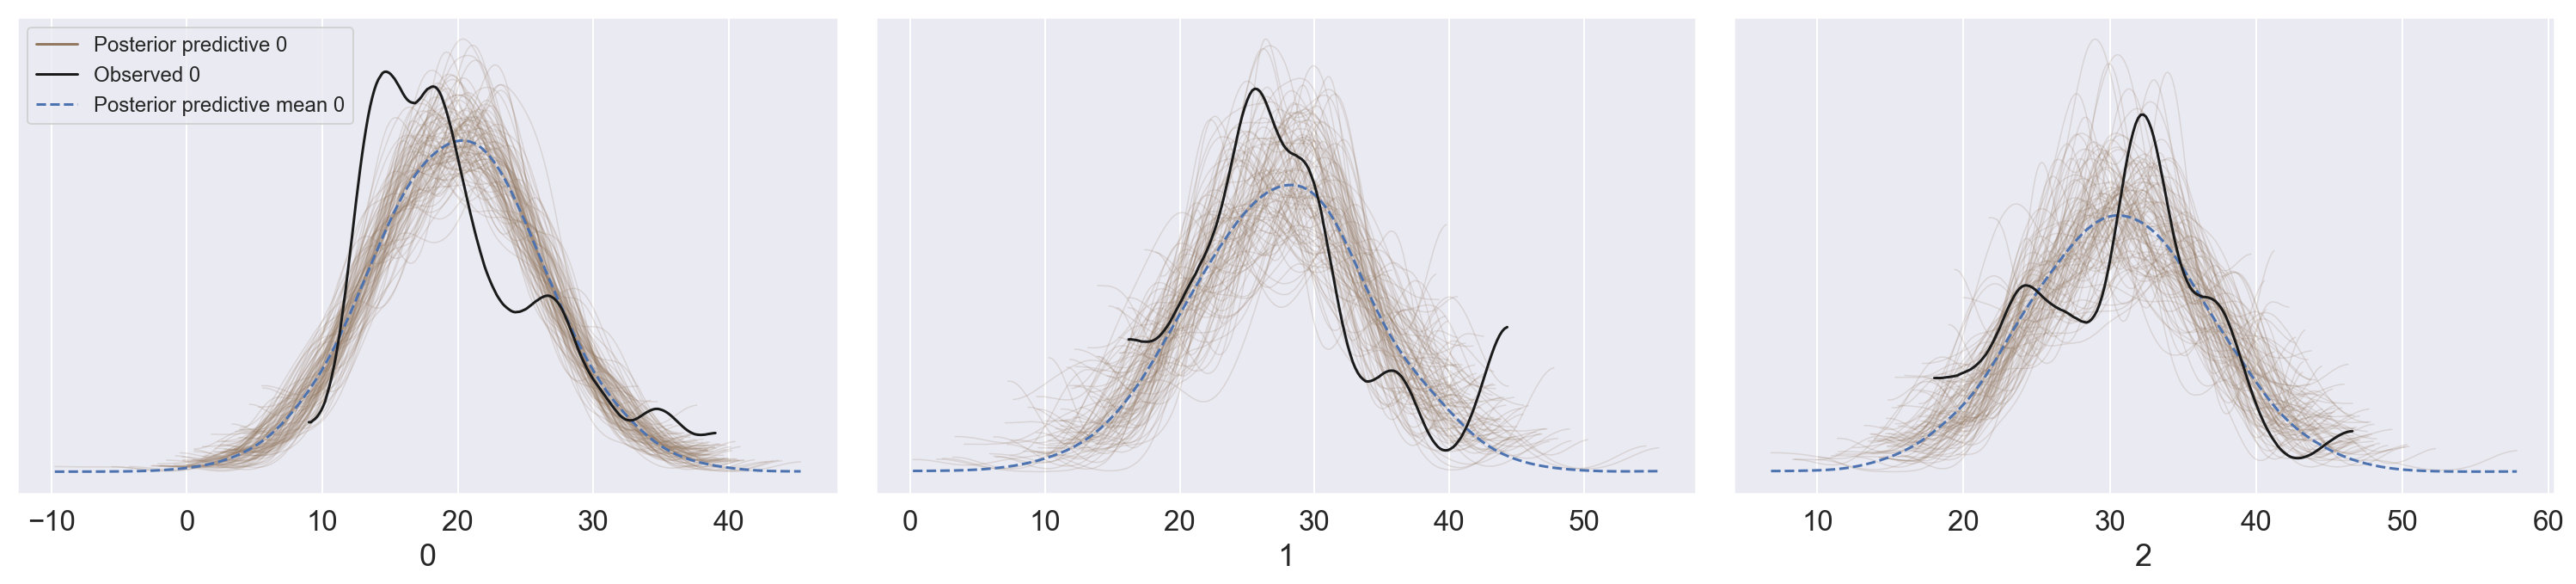

In [31]:
ax = az.plot_ppc(az_data, kind='density')
ax[0].legend(loc='upper left', fontsize=12)
ax[1].get_legend().remove()
ax[2].get_legend().remove()
plt.show()

### Forest plot

Since we have now quite many variables in the trace, a forest plot can give a useful quick visualization of the results.

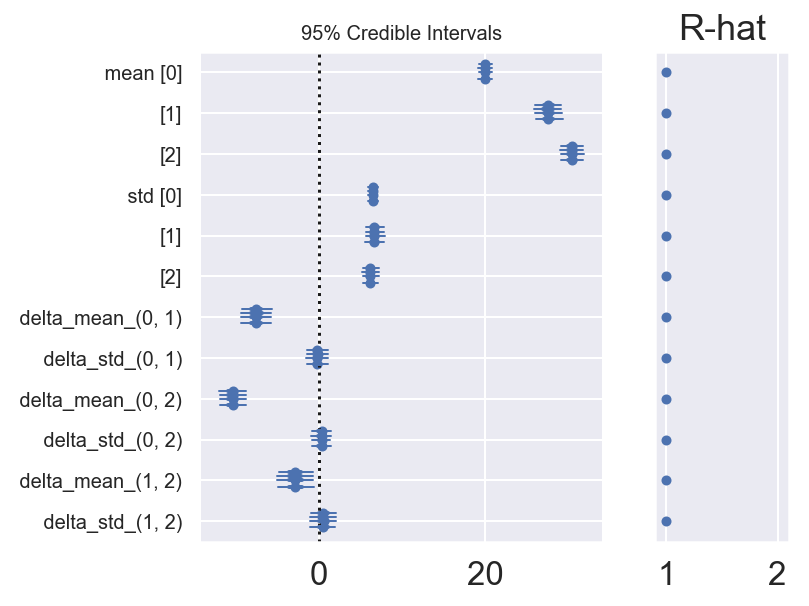

In [32]:
pm.forestplot(trace_v)
plt.show()

## Modifying the model

We can modify the model in various ways. 

- First we can change the prior for the standard deviation to a Gamma distribution which has the advantage of having support on all positive numbers.

- Second we can use a more robust distribution for the likelihood like the t-distribution. This brings an additional parameter $\nu$. For large values of $\nu$ we get a normal distribution, for small values the distribution becomes however broader. We choose priors in such a way that small values become likelier through an exponential distribution, but limit also to having values greater than one for the appropriate values of the t-distribution.

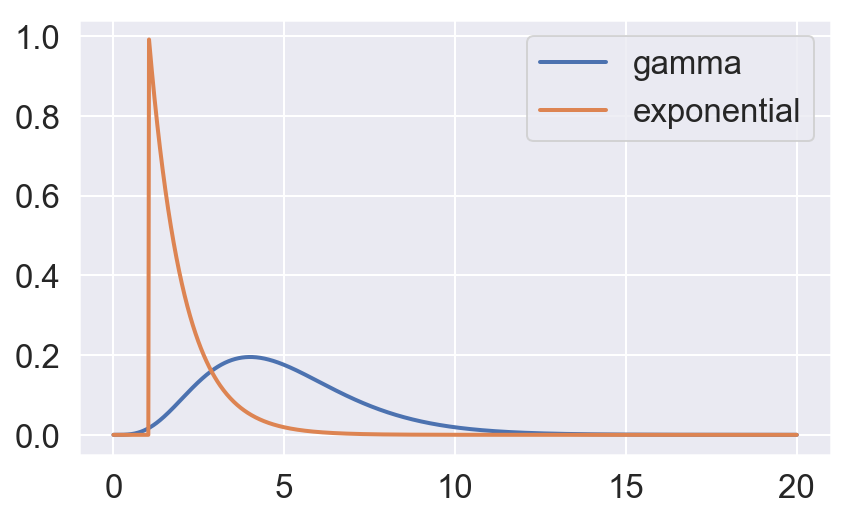

In [33]:
xvals = np.linspace(0,20,1000)
gamma_dist = stats.gamma(5)
yvals = gamma_dist.pdf(xvals)
exp_dist = stats.expon(1/30+1)
yvals = gamma_dist.pdf(xvals)
yvals_e = exp_dist.pdf(xvals)
plt.plot(xvals,yvals, lw=2, label='gamma')
plt.plot(xvals,yvals_e, lw=2, label='exponential')
plt.legend()
plt.show()

In [34]:
with pm.Model() as model_v1:
    
    mean = pm.Normal('mean', mu=prior_mean, sd=prior_mean_std, shape=n_groups)
    std = pm.Gamma('std', mu=5, sd=10, shape=n_groups)
    nu_minus1 = pm.Exponential('nu_minus1', 1/29)
    nu = pm.Deterministic('nu', nu_minus1+1)
    
    mpg = {}
    
    for i, observed in enumerate(mpg_values):
        mpg[i] = pm.StudentT('{}'.format(i), nu=nu, mu=mean[i], sd=std[i], observed=mpg_values[i])

    mean_delta = {}
    std_delta = {}
    
    for i,j in combinations(range(n_groups),2):
        mean_delta[(i,j)] = pm.Deterministic('delta_mean_{}'.format((i,j)), mean[i]-mean[j])
        std_delta[(i,j)] = pm.Deterministic('delta_std_{}'.format((i,j)), std[i]-std[j])

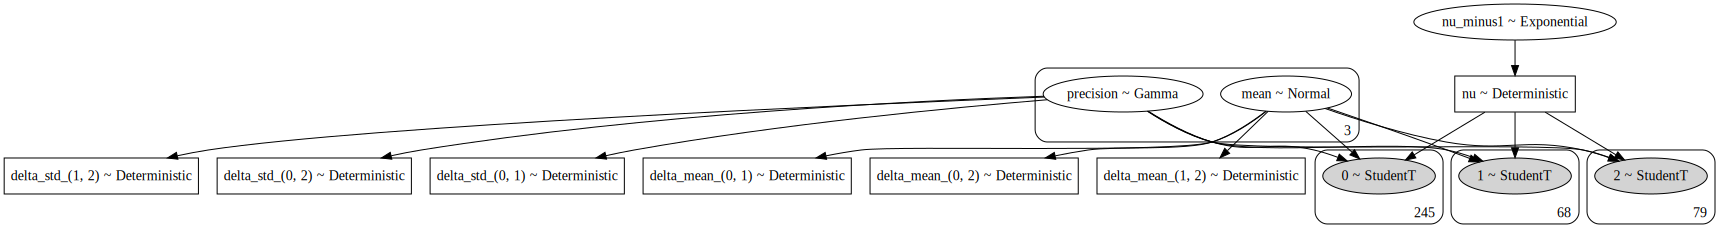

In [36]:
pm.model_to_graphviz(model_v1)

In [35]:
with model_v1:
    trace_v1 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_minus1, precision, mean]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:04<00:00, 672.16draws/s]


### Forest plot

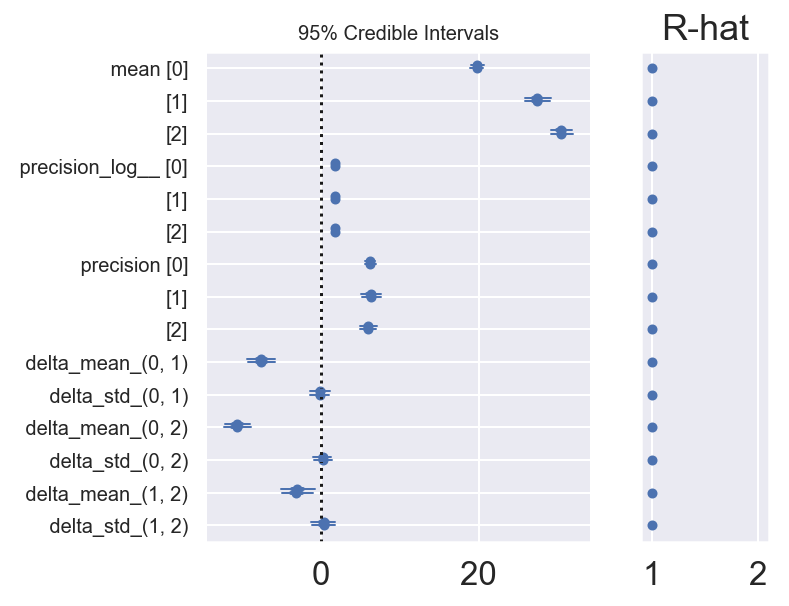

In [36]:
pm.forestplot(trace_v1, varnames=[name for name in trace_v1.varnames if 'nu' not in name])
plt.show()

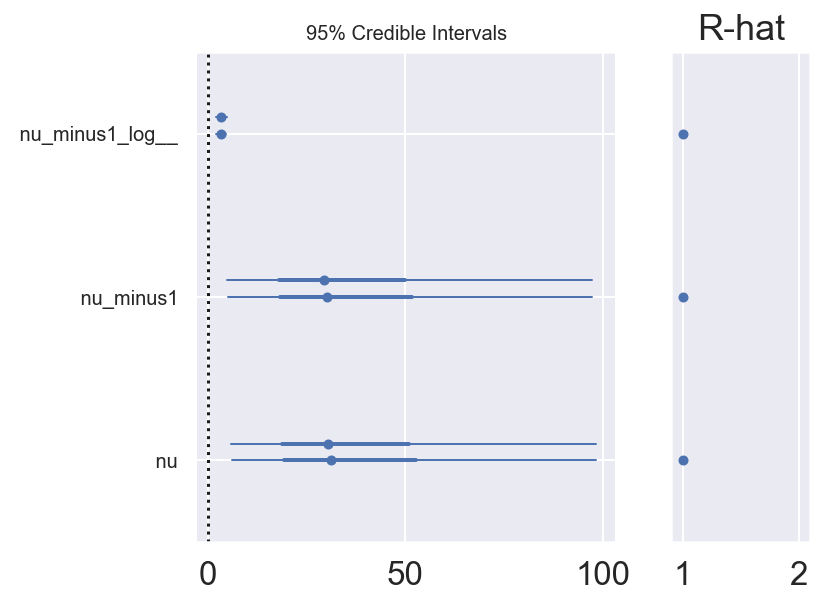

In [37]:
pm.forestplot(trace_v1, varnames=[name for name in trace_v1.varnames if 'nu' in name])
plt.show()

## Differences between brands

We took so far only the origin into account. We could build a hierarchical model taking also the individual brand statistics into account.


In [37]:
grouped_brands = df.groupby('brand')[['horsepower']].agg([np.mean,np.std])
grouped_brands

horsepower           
                  mean        std
brand                            
amc         114.703704  29.431557
audi         86.714286  11.842217
bmw         111.500000   2.121320
buick       136.411765  45.098585
cadillac    152.500000  38.890873
capri        92.000000        NaN
chevrolet   112.750000  35.435579
chevy       142.333333  59.045180
chrysler    153.666667  54.650404
datsun       83.826087  19.253458
dodge       117.178571  37.724198
fiat         73.375000  12.546343
ford        112.229167  37.139323
hi          193.000000        NaN
honda        67.846154  11.312575
mazda        77.666667  17.452967
mercedes     88.000000  28.160256
mercury     119.818182  48.157696
nissan       88.000000        NaN
oldsmobile  122.000000  37.357135
opel         81.000000   6.480741
peugeot      88.000000  19.654153
plymouth    111.419355  37.713635
pontiac     136.937500  51.815659
renault      70.000000  12.529964
saab        108.750000   9.464847
subaru       73.500000  13.000000
toyota       83.961538  18.173565
triumph      88.000000        NaN
volkswagen   64.136364  11.622210
volvo       104.166667  16.690317

In [38]:
brands = grouped_brands.dropna().index

In [52]:
brands[::-1]

Index(['volvo', 'volkswagen', 'toyota', 'subaru', 'saab', 'renault', 'pontiac',
       'plymouth', 'peugeot', 'opel', 'oldsmobile', 'mercury', 'mercedes',
       'mazda', 'honda', 'ford', 'fiat', 'dodge', 'datsun', 'chrysler',
       'chevy', 'chevrolet', 'cadillac', 'buick', 'bmw', 'audi', 'amc'],
      dtype='object', name='brand')

In [40]:
len(brands)

27

First we model only the brands.

In [41]:
with pm.Model() as model_b:
    
    
    mean = pm.Normal('mean', prior_mean, sd=prior_std, shape=len(brands))
    std = pm.Uniform('std', lower=prior_std_lower,upper=prior_std_upper, shape=len(brands))

    mpg = {}
    for i, brand in enumerate(brands):
        mpg[i] = pm.Normal('{}'.format(i), mu=mean[i], sd=std[i], observed=df.mpg[df.brand==brand].values)

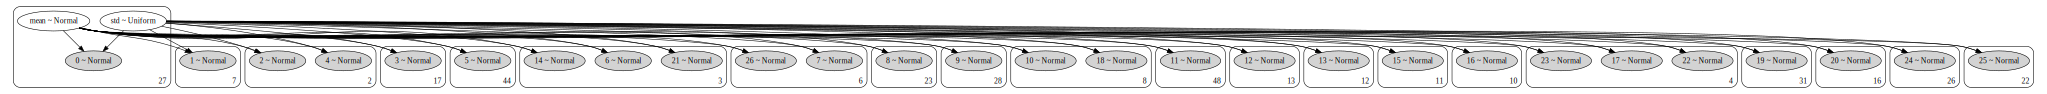

In [42]:
pm.model_to_graphviz(model_b)

In [43]:
with model_b:
    trace_b = pm.sample(5000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [std, mean]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:46<00:00, 238.38draws/s]


In [44]:
trace_b[0]

{'mean': array([17.91249059, 21.04412033, 24.28495001, 18.11420786, 13.99549733,
        20.7612024 , 19.92291394, 16.74453689, 31.21673119, 20.97994674,
        26.00791886, 18.7726851 , 34.11722732, 29.48640287, 28.31725951,
        20.14890257, 20.0789895 , 26.00668332, 21.87930203, 22.33947204,
        20.17673256, 27.78567807, 23.43356942, 30.18451475, 28.15325163,
        31.42787237, 18.83130146]),
 'std_interval__': array([-0.64146988,  0.35916288, -0.48248681,  0.3876789 ,  0.15309145,
         0.66704867,  0.43017756,  0.52906133,  0.32476967,  1.32943993,
         0.02471001,  0.39086964, -0.26640662,  0.90820095,  3.11014082,
         0.3329874 ,  1.62216279, -1.73392618,  0.06782152,  1.14870349,
         0.96298838, -0.42847129,  1.1582873 , -1.3568128 ,  0.20698746,
         0.80975765,  2.34119746]),
 'std': array([3.44915002, 5.88838187, 3.81665691, 5.95724222, 5.38198749,
        6.60842331, 6.05916462, 6.29264527, 5.80486635, 7.90748187,
        5.06177682, 5.9649243

In [46]:
pm.summary(trace)

mean        sd  mc_error    hpd_2.5   hpd_97.5  \
american_mean      20.028698  0.411748  0.003622  19.198886  20.799709   
european_mean      27.582581  0.807553  0.008786  25.953857  29.086930   
asian_mean         30.455694  0.708189  0.007029  29.071931  31.857411   
american_std        6.469251  0.289992  0.002704   5.884146   7.017653   
european_std        6.699378  0.581986  0.006990   5.598435   7.845358   
asian_std           6.193659  0.514358  0.005716   5.218851   7.224902   
delta_mean_am_eu   -7.553882  0.912059  0.009472  -9.287220  -5.758300   
delta_std_am_eu    -0.230127  0.653412  0.007661  -1.504016   1.031309   
delta_mean_am_as  -10.426995  0.809442  0.008217 -11.973999  -8.823576   
delta_std_am_as     0.275592  0.587848  0.006293  -0.901403   1.390162   
delta_mean_eu_as   -2.873113  1.085528  0.011839  -4.875743  -0.618083   
delta_std_euro_as   0.505719  0.776649  0.009359  -1.031656   2.002566   

                          n_eff      Rhat  
american_mean      12849.128373  1.000169  
european_mean       9145.247849  0.999969  
asian_mean         10969.989445  0.999903  
american_std       10782.485055  1.000081  
european_std        7392.928265  1.000211  
asian_std           8549.094602  0.999937  
delta_mean_am_eu    9642.234261  0.999900  
delta_std_am_eu     7703.502783  1.000370  
delta_mean_am_as   11373.275947  0.999946  
delta_std_am_as     9053.067512  1.000043  
delta_mean_eu_as    9770.657771  0.999925  
delta_std_euro_as   8116.674866  0.999984

### Forest plot

We can easily visualize which brands are within rope boundaries of the whole dataset's mean.

In [45]:
rope_boundaries = np.around(df.mpg.mean()+np.array([-1,1]),2)

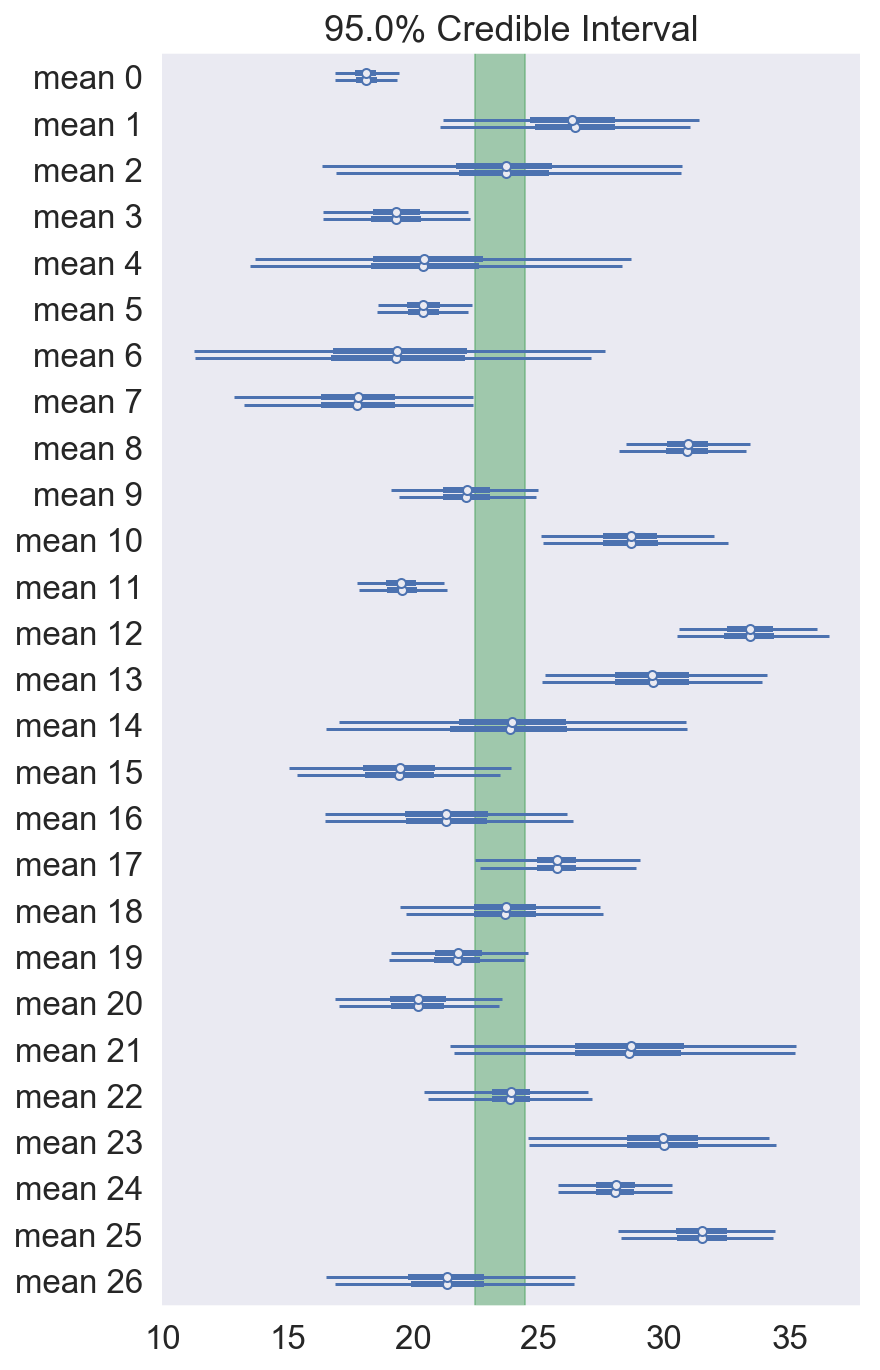

In [46]:
az.plot_forest(trace_b, credible_interval=0.95, var_names='mean', rope=rope_boundaries)
plt.show()

### Trace plot

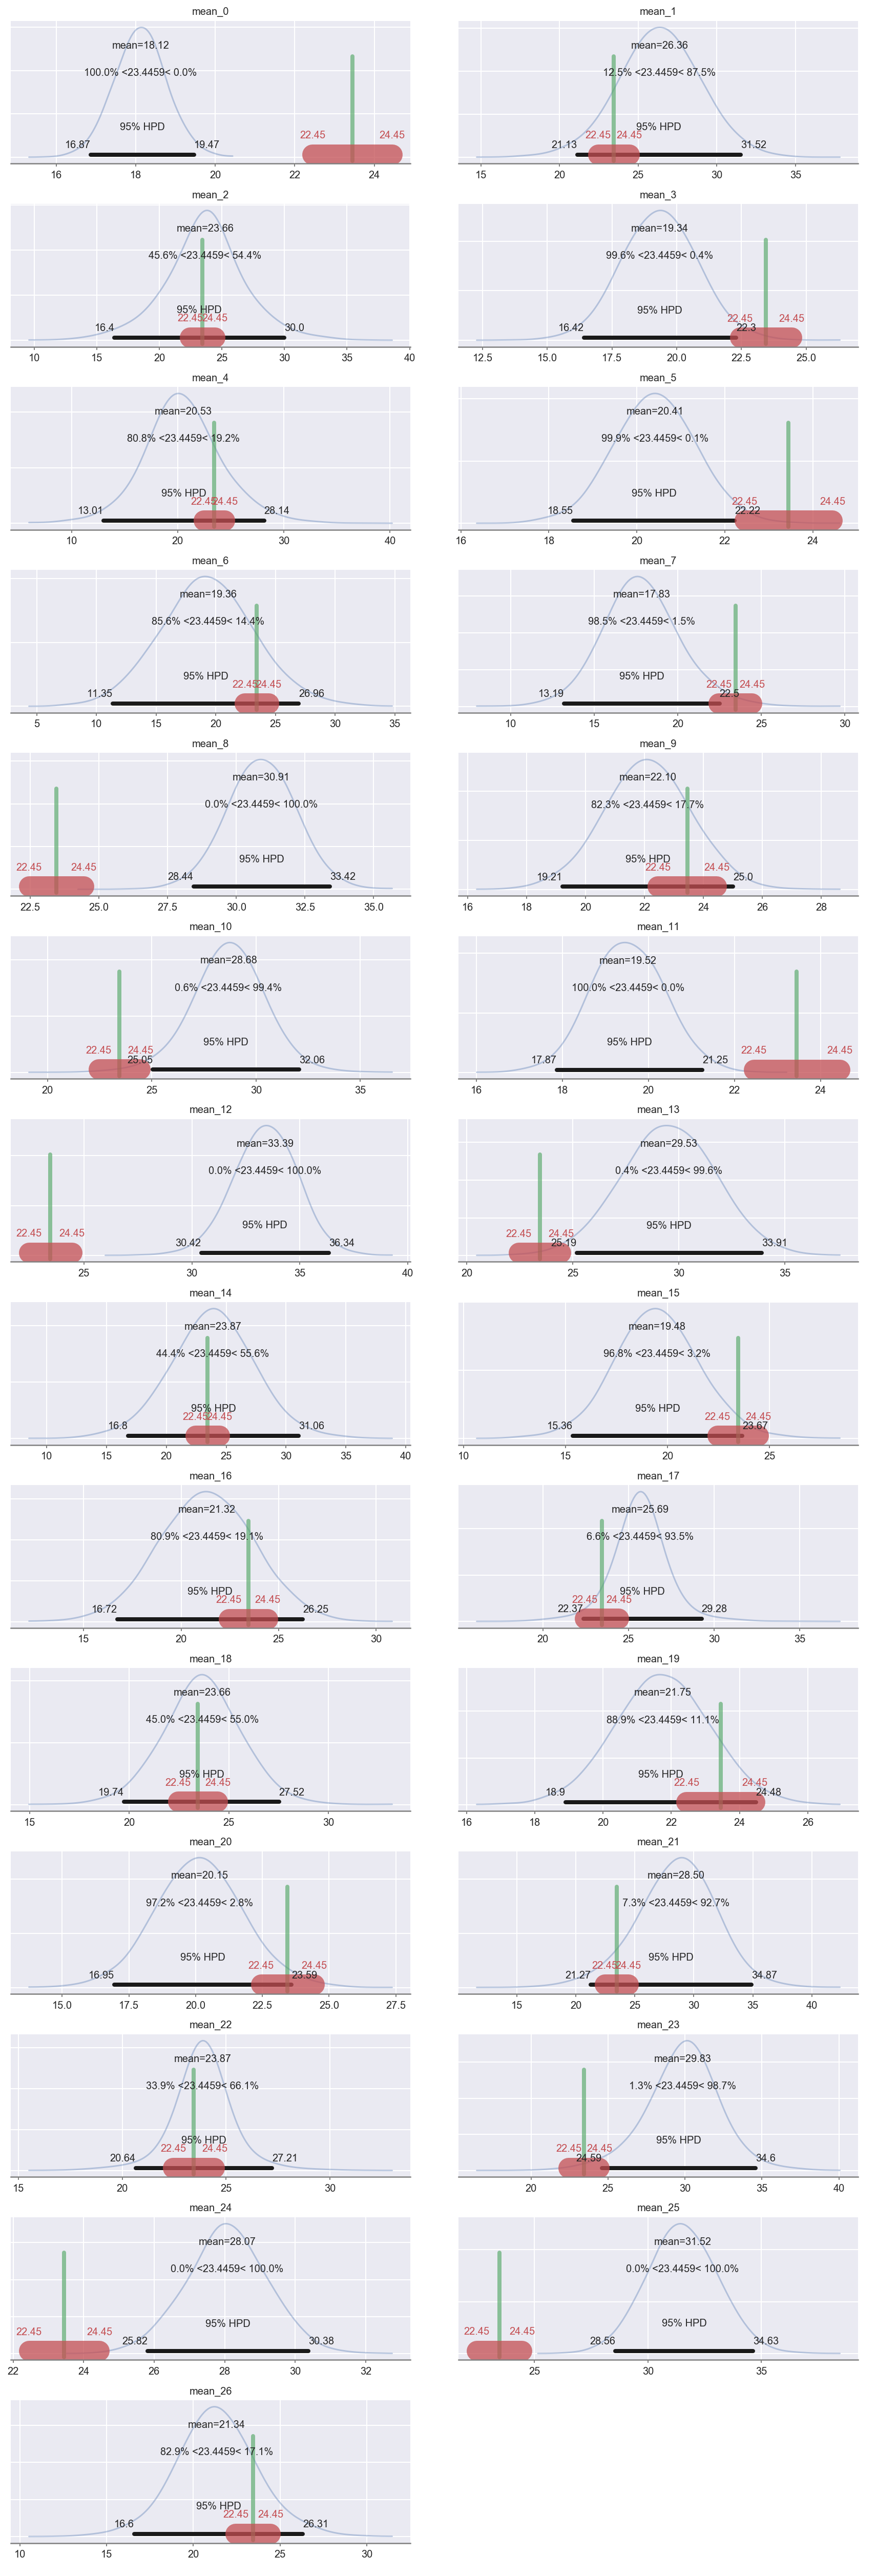

In [49]:
pm.plot_posterior(trace_b, varnames=['mean'],kde_plot=True, ref_val=df.mpg.mean(),round_to=2,rope=rope_boundaries)
plt.show()

## Hierarchical model of origin and brands

Now we construct a model where we determine the distribution of each brand influenced by the mean of each origin group itself adjusted to the mean of all observations.

In [53]:
grouped_brands = df.groupby(['origin','brand'])[['mpg']].agg([np.mean,np.std,lambda x: len(x)]).dropna()
grouped_brands

mpg                    
                        mean        std <lambda>
origin brand                                    
1      amc         18.070370   3.225358     27.0
       buick       19.182353   5.760993     17.0
       cadillac    19.750000   4.596194      2.0
       chevrolet   20.370455   6.147587     44.0
       chevy       18.000000  11.357817      3.0
       chrysler    17.266667   4.846304      6.0
       dodge       22.060714   7.574144     28.0
       ford        19.475000   5.936383     48.0
       mercury     19.118182   6.822143     11.0
       oldsmobile  21.100000   8.494181     10.0
       plymouth    21.703226   7.792367     31.0
       pontiac     20.012500   6.285632     16.0
2      audi        26.714286   6.632855      7.0
       bmw         23.750000   3.181981      2.0
       fiat        28.912500   4.102765      8.0
       mercedes    23.966667   6.863187      3.0
       opel        25.750000   1.707825      4.0
       peugeot     23.687500   4.767580      8.0
       renault     29.666667   5.507571      3.0
       saab        23.900000   1.604161      4.0
       volkswagen  31.840909   7.100480     22.0
       volvo       21.116667   5.000167      6.0
3      datsun      31.113043   5.721674     23.0
       honda       33.761538   4.764371     13.0
       mazda       30.058333   8.247144     12.0
       subaru      30.525000   3.397425      4.0
       toyota      28.165385   5.644320     26.0

Associate the origin mean with each brand name:

In [54]:
origin_means = [grouped_origin.loc[df.origin[df.brand==brand].max(),('mpg','mean')] for brand in brands]
origin_std = [grouped_origin.loc[df.origin[df.brand==brand].max(),('mpg','std')] for brand in brands]

In [55]:
brand_origin = [df.origin[df.brand==brand].max()-1 for brand in brands]

In [56]:
with pm.Model() as model_h:
    
    mean_origin = pm.Normal('mean_origin', prior_mean, sd=50, shape=len(df.origin.unique()))
    
    
    mean_brand = pm.Normal('mean_brand', [mean_origin[orig] for orig in brand_origin], sd=50, shape=len(brands))
    std_brand = pm.Uniform('std_brand', lower=prior_std_lower,upper=3*prior_std_upper, shape=len(brands))

   
    mpg = {}
    for i, brand in enumerate(brands):
        mpg[i] = pm.Normal('{}'.format(i), mu=mean_brand[i], sd=std_brand[i], 
                           observed=df.mpg[df.brand==brand].values)

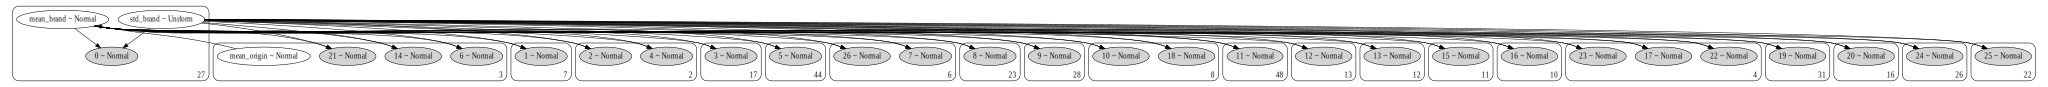

In [57]:
pm.model_to_graphviz(model_h)

In [58]:
with model_h:
    trace_h = pm.sample(5000, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std_brand, mean_brand, mean_origin]
Sampling 4 chains: 100%|██████████| 22000/22000 [01:52<00:00, 195.08draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [61]:
trace_h[0]

{'mean_origin': array([ 2.41188133, 27.08425106, 32.72469467]),
 'mean_brand': array([19.24670614, 24.56353334, 16.92612257, 21.12352046, 15.80385861,
        20.37270034, 22.72458646,  9.9419869 , 31.02573792, 21.7773582 ,
        29.69328538, 18.87598238, 36.30435479, 29.90317057, 23.61796768,
        16.66235074, 30.33929184, 26.93123148, 29.4945025 , 20.13496724,
        16.21234451, 27.70651647, 27.80361342, 32.87073845, 28.29803156,
        32.34876012, 22.4255845 ]),
 'std_brand_interval__': array([-1.85745108, -1.19123648,  1.24087277, -1.60848154, -1.75059888,
        -1.20844262, -1.17329778, -0.89985161, -1.4250713 , -1.19798229,
        -2.27735138, -1.60217677, -1.48392283, -1.32068148,  1.2453546 ,
        -1.14855589, -0.17193441, -2.23919391, -1.40936437, -1.01479648,
        -1.18215568, -1.12975297, -1.21428919, -2.18814809, -1.80715462,
        -1.30168738, -1.43256028]),
 'std_brand': array([ 4.05002143,  6.9911436 , 23.27147911,  5.0039945 ,  4.43915886,
         6

### Forest plot

In [62]:
az.plot_forest(trace_h,credible_interval=0.95, eff_n=True, r_hat=True)
plt.show()

TypeError: plot_forest() got an unexpected keyword argument 'eff_n'

### Trace plot

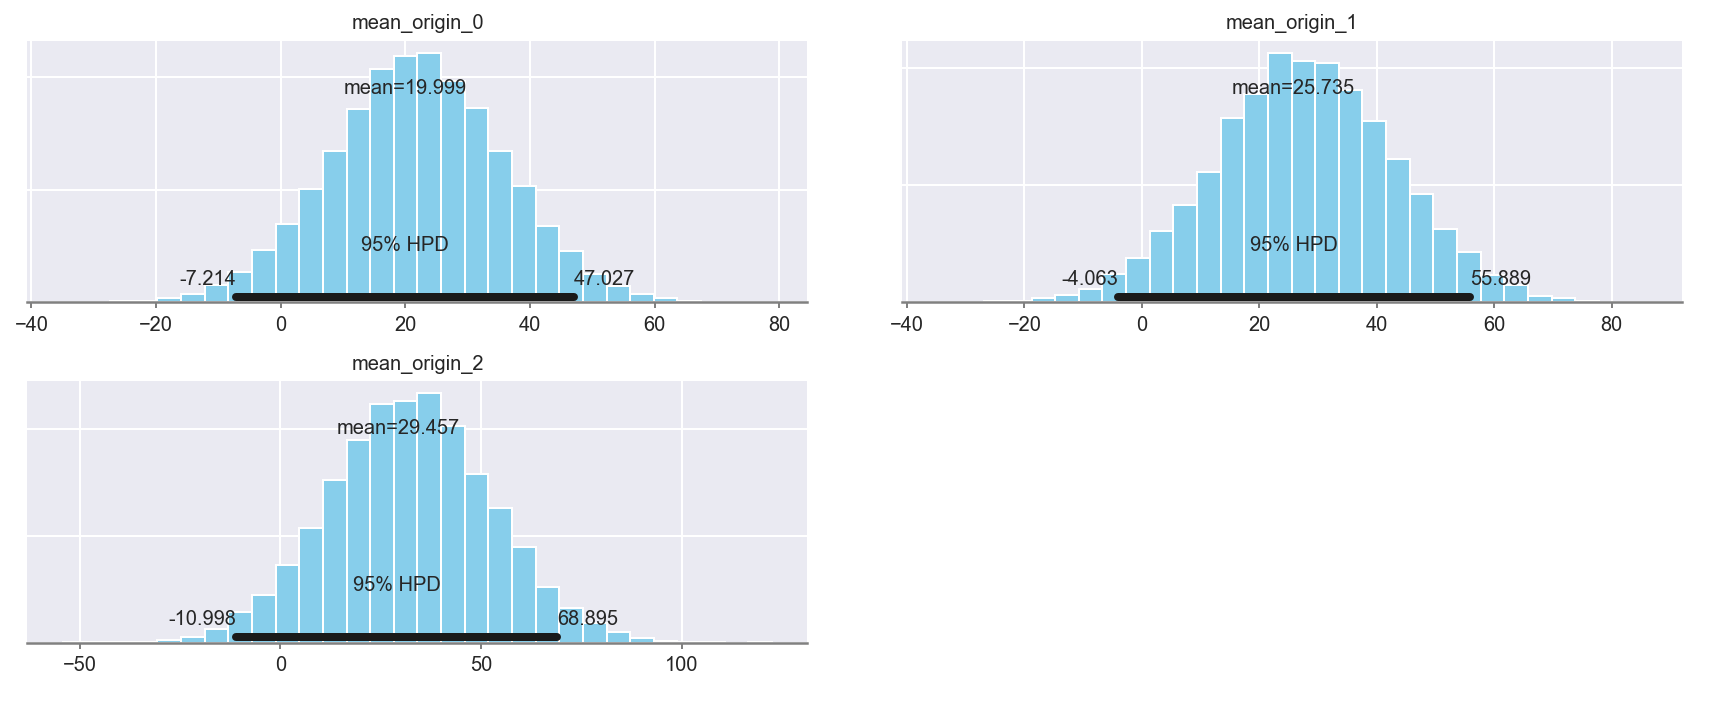

In [63]:
pm.plot_posterior(trace_h, varnames=['mean_origin'])
plt.show()

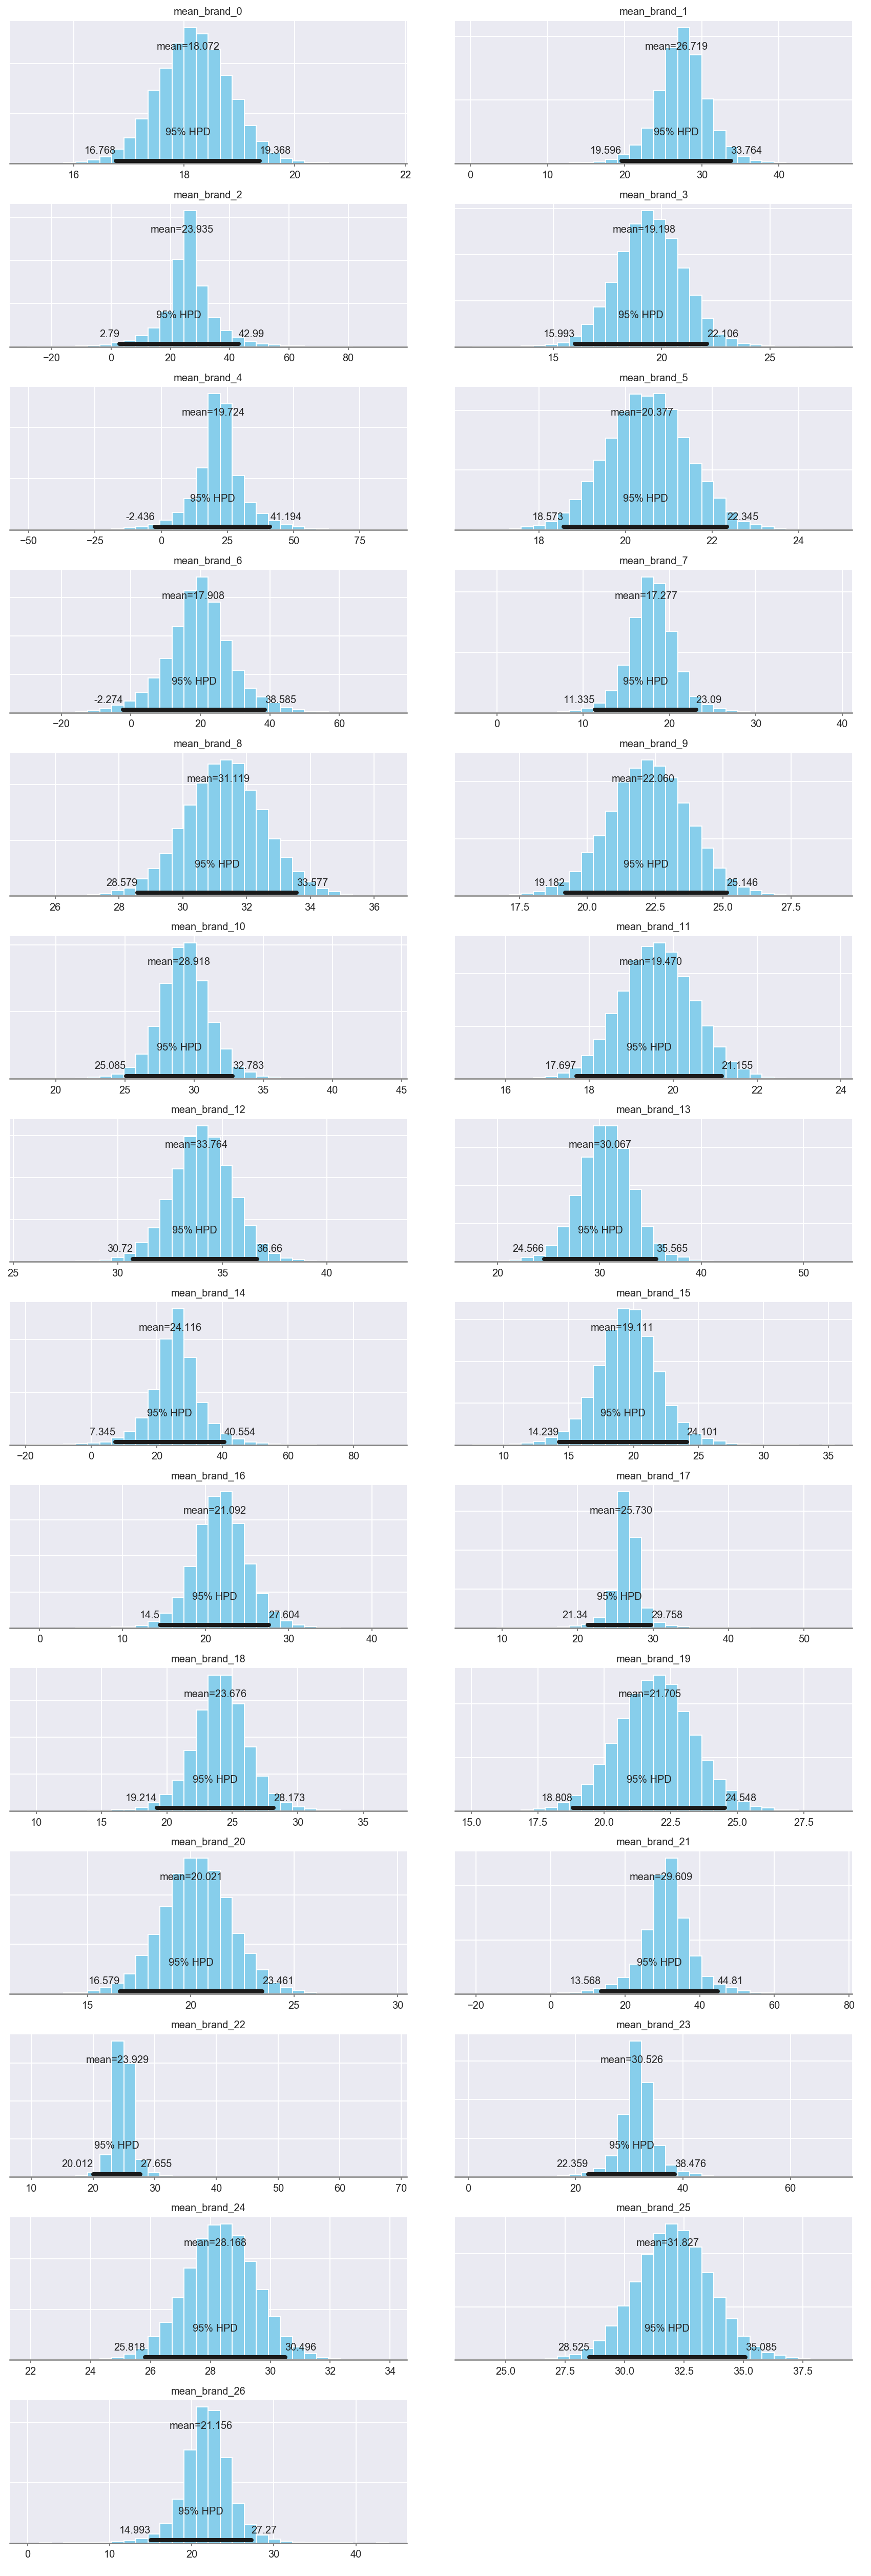

In [64]:
pm.plot_posterior(trace_h, varnames=['mean_brand'])
plt.show()

### Model summary

In [65]:
summary_h = pm.summary(trace_h)
summary_h

mean         sd  mc_error    hpd_2.5   hpd_97.5  \
mean_origin__0  19.998516  13.814236  0.069812  -7.213766  47.026589   
mean_origin__1  25.734941  15.313375  0.077157  -4.063326  55.888973   
mean_origin__2  29.456572  20.245590  0.083526 -10.998456  68.895126   
mean_brand__0   18.072029   0.662667  0.004304  16.767889  19.367556   
mean_brand__1   26.719330   3.489244  0.026520  19.595766  33.763558   
mean_brand__2   23.934723   9.124995  0.082323   2.789531  42.989879   
mean_brand__3   19.197806   1.558336  0.009905  15.993193  22.105666   
mean_brand__4   19.724180  10.010456  0.081240  -2.436191  41.193513   
mean_brand__5   20.377297   0.963249  0.004319  18.573101  22.345447   
mean_brand__6   17.908029   9.815411  0.078250  -2.273869  38.584515   
mean_brand__7   17.276855   2.907023  0.026555  11.334532  23.089897   
mean_brand__8   31.119168   1.266024  0.007889  28.578973  33.576940   
mean_brand__9   22.059864   1.510341  0.008500  19.182150  25.146260   
mean_brand__10  28.917708   1.923272  0.014314  25.084757  32.783177   
mean_brand__11  19.469811   0.884103  0.004686  17.697382  21.155200   
mean_brand__12  33.763617   1.500967  0.009752  30.720299  36.660207   
mean_brand__13  30.067273   2.770692  0.023649  24.566019  35.565207   
mean_brand__14  24.115793   7.905091  0.062531   7.344579  40.553675   
mean_brand__15  19.110893   2.441813  0.018141  14.239080  24.100967   
mean_brand__16  21.092495   3.288478  0.022809  14.500196  27.604193   
mean_brand__17  25.730169   2.259195  0.050822  21.339514  29.757667   
mean_brand__18  23.676409   2.231437  0.016760  19.214394  28.173366   
mean_brand__19  21.705015   1.457611  0.007697  18.808317  24.547779   
mean_brand__20  20.021156   1.740940  0.010036  16.578576  23.460844   
mean_brand__21  29.609478   7.263104  0.076666  13.567964  44.810342   
mean_brand__22  23.929125   1.997129  0.024945  20.011696  27.655150   
mean_brand__23  30.525980   3.869393  0.045375  22.359394  38.476062   
mean_brand__24  28.168470   1.186925  0.007524  25.818277  30.495650   
mean_brand__25  31.826662   1.651207  0.009176  28.525378  35.085028   
mean_brand__26  21.155853   3.043213  0.029701  14.992996  27.269655   
std_brand__0     3.395409   0.499192  0.002868   2.499827   4.385251   
std_brand__1     8.566685   3.255013  0.033441   3.999610  15.208753   
std_brand__2    11.151477   7.672299  0.087896   1.299133  26.718348   
std_brand__3     6.277006   1.266727  0.009994   4.134637   8.726522   
std_brand__4    12.586687   7.583087  0.087832   1.853697  27.201853   
std_brand__5     6.333043   0.703625  0.004126   5.012919   7.694043   
std_brand__6    16.219587   6.331390  0.063508   6.442616  28.814080   
std_brand__7     6.622159   2.981795  0.030719   2.702336  12.302108   
std_brand__8     6.075242   0.989327  0.006896   4.356228   8.071433   
std_brand__9     7.948793   1.135475  0.006018   5.873930  10.212441   
std_brand__10    5.103134   1.851994  0.018144   2.547166   8.781790   
std_brand__11    6.100035   0.652563  0.003903   4.882600   7.395324   
std_brand__12    5.342286   1.266701  0.009071   3.272595   7.829122   
std_brand__13    9.363281   2.404252  0.024918   5.602931  14.148797   
std_brand__14   12.463265   6.457348  0.080347   3.267741  25.803923   
std_brand__15    7.861389   2.137797  0.021066   4.429179  12.060541   
std_brand__16    9.982059   2.878047  0.025724   5.469226  15.707888   
std_brand__17    3.405753   2.995193  0.060685   0.789498   8.652837   
std_brand__18    5.938587   2.164382  0.023140   2.969543  10.139828   
std_brand__19    8.135904   1.098364  0.007872   6.139145  10.315859   
std_brand__20    6.873832   1.405795  0.009074   4.443909   9.590064   
std_brand__21   11.028596   6.410296  0.075708   2.555010  24.977651   
std_brand__22    3.176823   2.787797  0.042536   0.674474   7.903735   
std_brand__23    6.398984   4.447477  0.060316   1.573169  15.933590   
std_brand__24    5.939805   0.884949  0.005009   4.368068   7

In [66]:
summary_h.loc[:'mean_brand__26']

mean         sd  mc_error    hpd_2.5   hpd_97.5  \
mean_origin__0  19.998516  13.814236  0.069812  -7.213766  47.026589   
mean_origin__1  25.734941  15.313375  0.077157  -4.063326  55.888973   
mean_origin__2  29.456572  20.245590  0.083526 -10.998456  68.895126   
mean_brand__0   18.072029   0.662667  0.004304  16.767889  19.367556   
mean_brand__1   26.719330   3.489244  0.026520  19.595766  33.763558   
mean_brand__2   23.934723   9.124995  0.082323   2.789531  42.989879   
mean_brand__3   19.197806   1.558336  0.009905  15.993193  22.105666   
mean_brand__4   19.724180  10.010456  0.081240  -2.436191  41.193513   
mean_brand__5   20.377297   0.963249  0.004319  18.573101  22.345447   
mean_brand__6   17.908029   9.815411  0.078250  -2.273869  38.584515   
mean_brand__7   17.276855   2.907023  0.026555  11.334532  23.089897   
mean_brand__8   31.119168   1.266024  0.007889  28.578973  33.576940   
mean_brand__9   22.059864   1.510341  0.008500  19.182150  25.146260   
mean_brand__10  28.917708   1.923272  0.014314  25.084757  32.783177   
mean_brand__11  19.469811   0.884103  0.004686  17.697382  21.155200   
mean_brand__12  33.763617   1.500967  0.009752  30.720299  36.660207   
mean_brand__13  30.067273   2.770692  0.023649  24.566019  35.565207   
mean_brand__14  24.115793   7.905091  0.062531   7.344579  40.553675   
mean_brand__15  19.110893   2.441813  0.018141  14.239080  24.100967   
mean_brand__16  21.092495   3.288478  0.022809  14.500196  27.604193   
mean_brand__17  25.730169   2.259195  0.050822  21.339514  29.757667   
mean_brand__18  23.676409   2.231437  0.016760  19.214394  28.173366   
mean_brand__19  21.705015   1.457611  0.007697  18.808317  24.547779   
mean_brand__20  20.021156   1.740940  0.010036  16.578576  23.460844   
mean_brand__21  29.609478   7.263104  0.076666  13.567964  44.810342   
mean_brand__22  23.929125   1.997129  0.024945  20.011696  27.655150   
mean_brand__23  30.525980   3.869393  0.045375  22.359394  38.476062   
mean_brand__24  28.168470   1.186925  0.007524  25.818277  30.495650   
mean_brand__25  31.826662   1.651207  0.009176  28.525378  35.085028   
mean_brand__26  21.155853   3.043213  0.029701  14.992996  27.269655   

                       n_eff      Rhat  
mean_origin__0  37753.355138  0.999909  
mean_origin__1  35225.762268  0.999906  
mean_origin__2  42476.373699  0.999905  
mean_brand__0   30180.940930  0.999973  
mean_brand__1   16176.736069  0.999955  
mean_brand__2   11013.459576  1.000456  
mean_brand__3   26372.392578  0.999925  
mean_brand__4   12757.837161  1.000200  
mean_brand__5   31959.010070  0.999955  
mean_brand__6   14932.572049  1.000180  
mean_brand__7   12391.608115  0.999964  
mean_brand__8   25792.896876  0.999939  
mean_brand__9   31747.591058  1.000089  
mean_brand__10  16479.320945  0.999921  
mean_brand__11  37764.030439  0.999903  
mean_brand__12  23315.301332  0.999979  
mean_brand__13  15808.357198  0.999966  
mean_brand__14  12926.799846  0.999986  
mean_brand__15  23275.726308  0.999910  
mean_brand__16  19843.650846  1.000123  
mean_brand__17   1819.255302  1.002235  
mean_brand__18  17526.442896  0.999940  
mean_brand__19  30541.313383  0.999995  
mean_brand__20  29798.169213  0.999947  
mean_brand__21  10486.525121  1.000110  
mean_brand__22   5190.774791  1.000130  
mean_brand__23   6563.823017  1.000062  
mean_brand__24  28276.326303  0.999934  
mean_brand__25  30984.085819  0.999919  
mean_brand__26  12879.638902  1.000621

### Adjusted means

In [67]:
pd.DataFrame({'brands':summary_h.loc['mean_brand__0':'mean_brand__26','mean'].values,
              'origin':np.array(origin_means),
              'overall':[prior_mean]*len(brands)},index=brands).T

brand          amc       audi        bmw      buick   cadillac  chevrolet  \
brands   18.072029  26.719330  23.934723  19.197806  19.724180  20.377297   
origin   20.033469  27.602941  27.602941  20.033469  20.033469  20.033469   
overall  23.445918  23.445918  23.445918  23.445918  23.445918  23.445918   

brand        chevy   chrysler     datsun      dodge       fiat       ford  \
brands   17.908029  17.276855  31.119168  22.059864  28.917708  19.469811   
origin   20.033469  20.033469  30.450633  20.033469  27.602941  20.033469   
overall  23.445918  23.445918  23.445918  23.445918  23.445918  23.445918   

brand        honda      mazda   mercedes    mercury  oldsmobile       opel  \
brands   33.763617  30.067273  24.115793  19.110893   21.092495  25.730169   
origin   30.450633  30.450633  27.602941  20.033469   20.033469  27.602941   
overall  23.445918  23.445918  23.445918  23.445918   23.445918  23.445918   

brand      peugeot   plymouth    pontiac    renault       saab     subaru  \
brands   23.676409  21.705015  20.021156  29.609478  23.929125  30.525980   
origin   27.602941  20.033469  20.033469  27.602941  27.602941  30.450633   
overall  23.445918  23.445918  23.445918  23.445918  23.445918  23.445918   

brand       toyota  volkswagen      volvo  
brands   28.168470   31.826662  21.155853  
origin   30.450633   27.602941  27.602941  
overall  23.445918   23.445918  23.445918

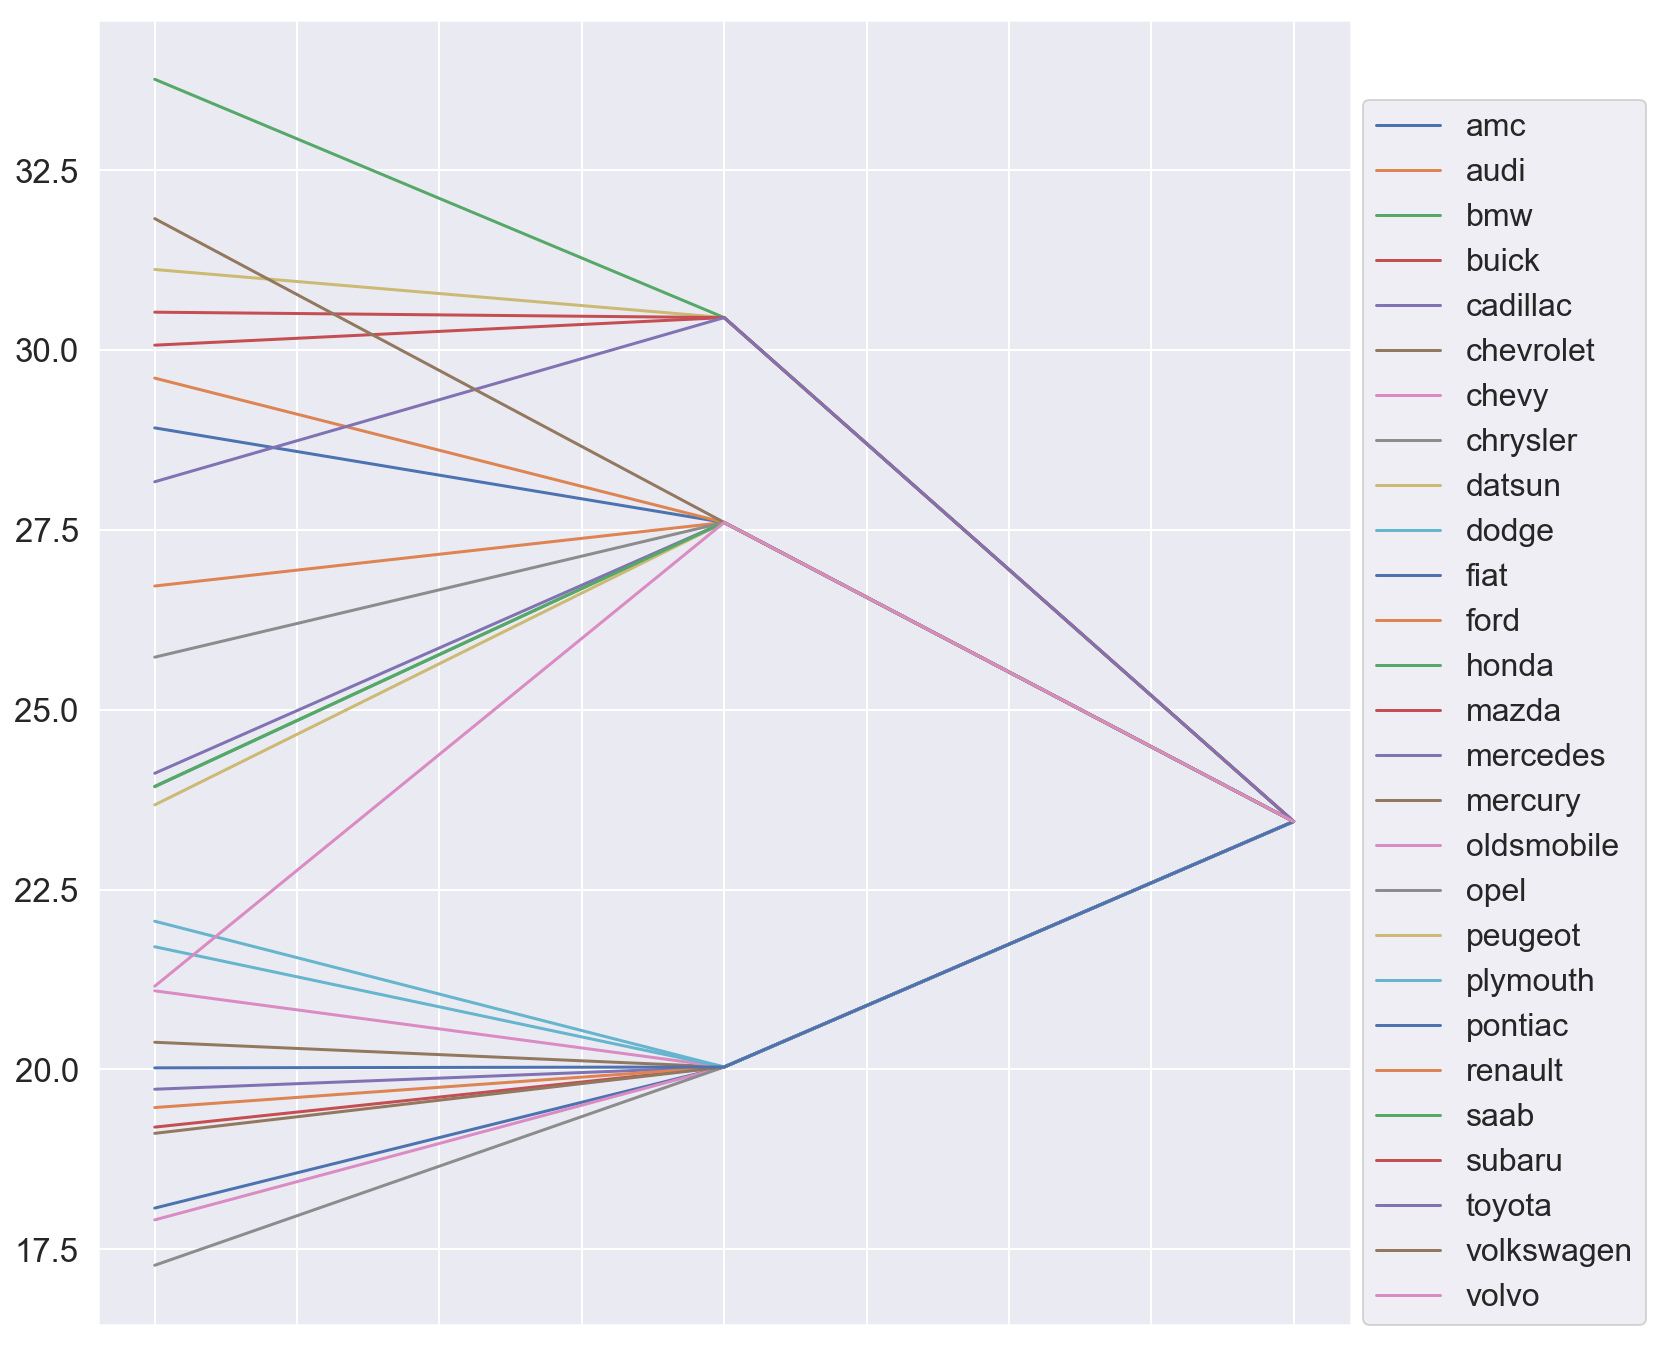

In [68]:
pd.DataFrame({'brands':summary_h.loc['mean_brand__0':'mean_brand__26','mean'].values,
              'origin':np.array(origin_means),
              'overall':[prior_mean]*len(brands)},
              index=brands).T.plot(figsize=(10,12))
plt.legend(loc=[1.01,0],fontsize=16)
plt.show()

In [69]:
mean_adjustment = grouped_brands.reset_index().iloc[:,1:3].sort_values(by='brand').reset_index(drop=True)
mean_adjustment['hierarchical'] = summary_h.loc['mean_brand__0':'mean_brand__26','mean'].values
mean_adjustment

brand        mpg hierarchical
                     mean             
0          amc  18.070370    18.072029
1         audi  26.714286    26.719330
2          bmw  23.750000    23.934723
3        buick  19.182353    19.197806
4     cadillac  19.750000    19.724180
5    chevrolet  20.370455    20.377297
6        chevy  18.000000    17.908029
7     chrysler  17.266667    17.276855
8       datsun  31.113043    31.119168
9        dodge  22.060714    22.059864
10        fiat  28.912500    28.917708
11        ford  19.475000    19.469811
12       honda  33.761538    33.763617
13       mazda  30.058333    30.067273
14    mercedes  23.966667    24.115793
15     mercury  19.118182    19.110893
16  oldsmobile  21.100000    21.092495
17        opel  25.750000    25.730169
18     peugeot  23.687500    23.676409
19    plymouth  21.703226    21.705015
20     pontiac  20.012500    20.021156
21     renault  29.666667    29.609478
22        saab  23.900000    23.929125
23      subaru  30.525000    30.525980
24      toyota  28.165385    28.168470
25  volkswagen  31.840909    31.826662
26       volvo  21.116667    21.155853

## Robust model

In [70]:
with pm.Model() as model_v1:
    
    mean = pm.Normal('mean', mu=prior_mean, sd=prior_mean_std, shape=n_groups)
    std = pm.Gamma('std', mu=5, sd=10, shape=n_groups)
    nu_minus1 = pm.Exponential('nu_minus1', 1/29)
    nu = pm.Deterministic('nu', nu_minus1+1)
    
    mpg = {}
    
    for i, observed in enumerate(mpg_values):
        mpg[i] = pm.StudentT('{}'.format(i), nu=nu, mu=mean[i], sd=std[i], observed=mpg_values[i])

    mean_delta = {}
    std_delta = {}
    
    for i,j in combinations(range(n_groups),2):
        mean_delta[(i,j)] = pm.Deterministic('delta_mean_{}'.format((i,j)), mean[i]-mean[j])
        std_delta[(i,j)] = pm.Deterministic('delta_std_{}'.format((i,j)), std[i]-std[j])

In [71]:
with pm.Model() as model_hi:
    
    mean_origin = pm.Normal('mean_origin', prior_mean, sd=50, shape=n_groups)
    std_origin = pm.Gamma('std_origin', mu=5, sd=10, shape=n_groups)
    
    mean_brand = pm.Normal('mean_brand', [mean_origin[orig] for orig in brand_origin], sd=50, shape=len(brands))
    std_brand = pm.Gamma('std_brand', mu=5, sd=10, shape=len(brands))

    nu_minus1 = pm.Exponential('nu_minus1', 1/29)
    nu = pm.Deterministic('nu', nu_minus1+1)
   
    mpg = {}
    for i, brand in enumerate(brands):
        mpg[i] = pm.StudentT('{}'.format(i), nu=nu, mu=mean_brand[i], sd=std_brand[i], 
                           observed=df.mpg[df.brand==brand].values)

In [72]:
with model_hi:
    trace_hi = pm.sample(5000, nuts_kwargs={'target_accept':0.95}, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus1, std_brand, mean_brand, std_origin, mean_origin]
Sampling 4 chains: 100%|██████████| 24000/24000 [02:49<00:00, 141.24draws/s]
The number of effective samples is smaller than 25% for some parameters.


### Forest plot

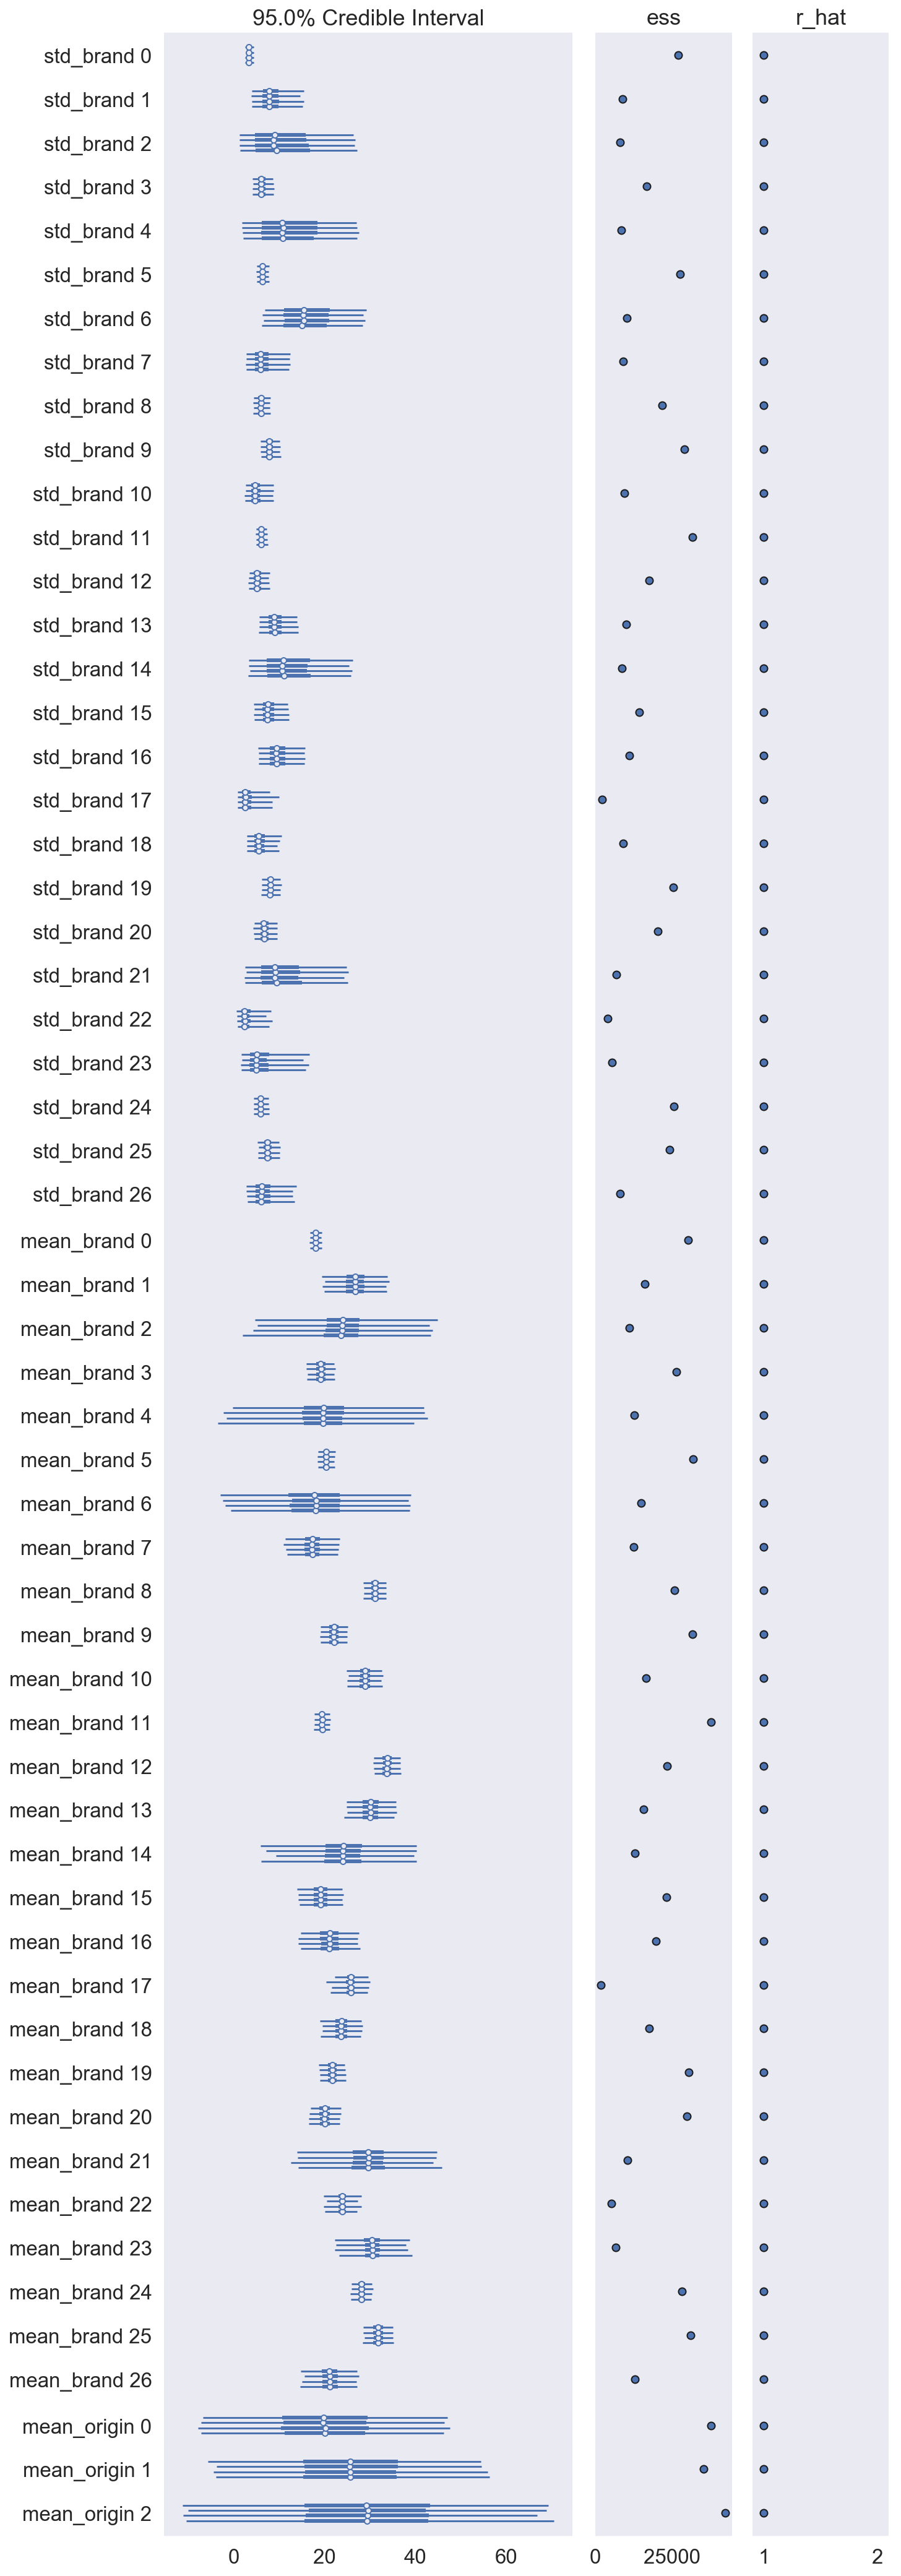

In [75]:
az.plot_forest(trace_h,credible_interval=0.95, ess=True, r_hat=True)
plt.show()

### Summary

In [74]:
pm.summary(trace_hi)

mean         sd  mc_error       hpd_2.5    hpd_97.5  \
mean_origin__0  19.854126  13.866301  0.069980 -7.912285e+00   46.467520   
mean_origin__1  25.732138  15.182737  0.073568 -5.132611e+00   54.531428   
mean_origin__2  29.515578  20.424658  0.093280 -9.263245e+00   70.799852   
mean_brand__0   17.989441   0.635904  0.003472  1.678903e+01   19.276998   
mean_brand__1   26.630852   2.987864  0.019802  2.036116e+01   32.383813   
mean_brand__2   23.725118   5.858695  0.082522  1.148885e+01   34.733613   
mean_brand__3   19.080881   1.504774  0.008863  1.611603e+01   22.004780   
mean_brand__4   19.954509   7.310605  0.100080  5.869239e+00   34.913333   
mean_brand__5   20.256834   0.970953  0.004955  1.837749e+01   22.191387   
mean_brand__6   17.962317   8.499418  0.075807  7.370705e-01   35.498600   
mean_brand__7   17.160888   2.425552  0.016782  1.220490e+01   21.972346   
mean_brand__8   31.113890   1.275021  0.007014  2.862891e+01   33.660475   
mean_brand__9   21.960708   1.506291  0.007265  1.890704e+01   24.844368   
mean_brand__10  28.811082   1.687846  0.011303  2.544171e+01   32.191625   
mean_brand__11  19.334695   0.880470  0.004226  1.761168e+01   21.041863   
mean_brand__12  33.733338   1.398513  0.007963  3.095384e+01   36.537887   
mean_brand__13  30.004939   2.568921  0.013731  2.487318e+01   35.064412   
mean_brand__14  24.109177   5.949311  0.056849  1.185591e+01   35.844479   
mean_brand__15  18.872009   2.200385  0.014628  1.446675e+01   23.246796   
mean_brand__16  20.984073   2.998879  0.018847  1.492809e+01   26.867654   
mean_brand__17  25.720222   1.388822  0.014957  2.296587e+01   28.385545   
mean_brand__18  23.706855   1.952282  0.013586  1.976849e+01   27.524097   
mean_brand__19  21.472706   1.464492  0.006791  1.856190e+01   24.303146   
mean_brand__20  19.855064   1.705694  0.010899  1.663368e+01   23.355404   
mean_brand__21  29.449351   5.164124  0.049462  1.842996e+01   39.613242   
mean_brand__22  23.928425   1.260167  0.012490  2.144564e+01   26.594355   
mean_brand__23  30.509732   2.655385  0.027645  2.496530e+01   35.604444   
mean_brand__24  28.119036   1.155091  0.006694  2.586979e+01   30.429633   
mean_brand__25  31.666758   1.618256  0.009809  2.850033e+01   34.917331   
mean_brand__26  20.927955   2.470209  0.019297  1.613322e+01   25.827574   
...                   ...        ...       ...           ...         ...   
std_origin__2    5.032204  10.245574  0.055082  8.399254e-18   24.319481   
std_brand__0     3.164356   0.501261  0.002994  2.217037e+00    4.135318   
std_brand__1     7.365129   2.577633  0.021669  3.593623e+00   12.484646   
std_brand__2     6.121237   6.202483  0.076038  8.775717e-01   17.308875   
std_brand__3     5.915193   1.149347  0.006739  3.866877e+00    8.161963   
std_brand__4     7.809897   7.244121  0.102823  1.208984e+00   20.835921   
std_brand__5     6.130665   0.715941  0.003476  4.870454e+00    7.638557   
std_brand__6    13.384243   7.430019  0.062706  4.010697e+00   27.675441   
std_brand__7     5.478146   2.178389  0.018920  2.370510e+00    9.741313   
std_brand__8     5.828440   0.946250  0.006037  4.150029e+00    7.717931   
std_brand__9     7.639939   1.097003  0.005799  5.580305e+00    9.777078   
std_brand__10    4.424726   1.462225  0.010956  2.109087e+00    7.272893   
std_brand__11    5.820278   0.653538  0.003247  4.618037e+00    7.137159   
std_brand__12    4.813746   1.154017  0.007862  2.864678e+00    7.133347   
std_brand__13    8.517120   2.081156  0.014192  5.059778e+00   12.650607   
std_brand__14    8.996124   5.731640  0.057599  2.535463e+00   20.060780   
std_brand__15    6.882599   1.821930  0.013522  3.844006e+00   10.485334   
std_brand__16    8.901775   2.435598  0.013851  4.996848e+00   13.747527   
std_brand__17    2.353904   1.617273  0.018611  7.203410e-01    5.148228   
std_brand__18    5.208535   1.649991  0.012483  2.769720e+00    8.501705   
std_brand__19    7.733671   1.086969  0.006264  5.718873e+00    9.903